# Инициализация библиотек

In [344]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Часть 1. Классификатор 128×128

## Инициализация данных

In [2]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        root_dir: путь до папки tiny-imagenet-200
        split: 'train', 'val' или 'test'
        transform: трансформации изображений
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        # сохранение названий классов в wnids.txt
        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            self.class_names = [line.strip() for line in f]
        
        #  создание поля id - классов
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}

        self.samples = []
        if split == 'train':
            train_dir = os.path.join(root_dir, 'train')
            for cls in os.listdir(train_dir):
                img_dir = os.path.join(train_dir, cls, 'images')
                if not os.path.exists(img_dir):
                    continue
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        elif split == 'val':
            val_dir = os.path.join(root_dir, 'val', 'images')
            anno_path = os.path.join(root_dir, 'val', 'val_annotations.txt')

            label_map = {}
            with open(anno_path, 'r') as f:
                for line in f:
                    img_name, cls, *_ = line.strip().split('\t')
                    label_map[img_name] = cls

            for img_name in os.listdir(val_dir):
                cls = label_map.get(img_name)
                if cls:
                    img_path = os.path.join(val_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        else:
            test_dir = os.path.join(root_dir, 'test', 'images')
            for img_name in os.listdir(test_dir):
                img_path = os.path.join(test_dir, img_name)
                self.samples.append((img_path, -1))  # тест без меток

    # возврат количества примеров в датасете
    def __len__(self):
        return len(self.samples)

    # загрузка и возврат одного примера (изображение + метка)
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')

        # преобразование изображение в соответсвии с transform
        if self.transform:
            img = self.transform(img)
        return img, label

In [3]:
class CustomDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

In [4]:
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Аугментация обучающей выборки
train_transform = transforms.Compose([
    transforms.Resize((128, 128)), # изменение размера на 128х128
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)), # случайно изменяем размер и обрезаем изображения в наборе данных - определяем верхние и нижние границы для случайной области
    transforms.RandomHorizontalFlip(p=0.5), # горизонтальное отзеркаливание с вероятнотью р = 0.5
    transforms.RandomRotation(10), # поворот изображения на 10 градусов
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # изменение яркости изображения
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
root = 'tiny-imagenet-200'

train_dataset = TinyImageNetDataset(root, split='train', transform=val_transform)

print(f"Train size: {len(train_dataset)}")
print(f"Классов: {len(train_dataset.class_names)}")

Train size: 100000
Классов: 200


- создаем валдиационную выборку

In [6]:
all_samples = train_dataset.samples
val_fraction = 0.2

X = [x for x, y in all_samples]  # пути к изображениям
y = [y for x, y in all_samples]  # метки классов

print(f" Подготовлено {len(X)} образцов с {len(set(y))} классами")

sss = StratifiedShuffleSplit(n_splits=1, test_size=val_fraction, random_state=42)
train_idx, val_idx = next(sss.split(X, y))

# Создаем стратифицированные разделения
train_split_stratified = [all_samples[i] for i in train_idx]
val_split_stratified = [all_samples[i] for i in val_idx]

print(f" Стратифицированное разделение:")
print(f"   Train: {len(train_split_stratified)} образцов")
print(f"   Val: {len(val_split_stratified)} образцов")


 Подготовлено 100000 образцов с 200 классами
 Стратифицированное разделение:
   Train: 80000 образцов
   Val: 20000 образцов


In [7]:
selected_classes = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27]  # 10 классов
selected_wnids = [train_dataset.class_names[clas] for clas in selected_classes]

train_subset_samples = [s for s in train_split_stratified if s[1] in selected_classes]
val_subset_samples = [s for s in val_split_stratified if s[1] in selected_classes]

# Переопределяем классы чтобы не было проблем с обучением 
class_to_new_idx = {cls: i for i, cls in enumerate(selected_classes)}

def remap_samples(samples):
    return [(path, class_to_new_idx[label]) for path, label in samples]

train_subset_samples = remap_samples(train_subset_samples)
val_subset_samples = remap_samples(val_subset_samples)

train_subset_dataset = CustomDataset(train_subset_samples, transform=train_transform)
val_subset_dataset = CustomDataset(val_subset_samples, transform=val_transform)

train_loader = DataLoader(train_subset_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset_dataset, batch_size=64, shuffle=False)


print(f'Всего классов : {len(selected_classes)}')
print(f'Обьем обучающей выборки : {len(train_subset_samples)}')
print(f'Обьем валидационной выборки : {len(val_subset_samples)}')

Всего классов : 10
Обьем обучающей выборки : 4000
Обьем валидационной выборки : 1000


In [8]:
with open(os.path.join(root, 'words.txt'), 'r') as f:
    wnid_word = {}
    for line in f:
        wnid, word = line.strip().split('\t', 1)
        wnid_word[wnid] = word

class_names = [wnid_word[wnid].split(",")[0] for wnid in selected_wnids]
print(class_names)

['Egyptian cat', 'rocking chair', 'basketball', 'plunger', 'dining table', 'school bus', 'umbrella', 'maypole', 'hourglass', 'Arabian camel']


## Определение Basic Block

In [9]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_chanels, stride = 1, activation = 'relu'):
        super().__init__()

        self.conv_1 = nn.Conv2d(in_channels= in_channels, out_channels=out_chanels, kernel_size= 3, padding=1, stride=stride, bias=False)
        self.bn_1 = nn.BatchNorm2d(out_chanels)

        self.conv_2 = nn.Conv2d(in_channels= out_chanels, out_channels= out_chanels, kernel_size= 3, padding= 1, stride= 1, bias=False)
        self.bn_2 = nn.BatchNorm2d(out_chanels)

        # Выбор функции активации
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'leakyrelu':
            self.activation = nn.LeakyReLU(inplace=True)
        elif activation == 'elu':
            self.activation = nn.ELU(inplace=True)
        elif activation == 'gelu':
            self.activation = nn.GELU()

        self.downsample = nn.Identity()

        if in_channels != out_chanels or stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels= out_chanels, kernel_size=1, padding=0, stride = stride, bias=False),
                nn.BatchNorm2d(out_chanels)
            )

    def forward(self, x):

        x_0 = self.downsample(x)

        x = self.activation(self.bn_1(self.conv_1(x)))
        x = self.bn_2(self.conv_2(x))

        # Skip connection
        x += x_0
        x = self.activation(x)

        return x
    
basic_block = BasicBlock(3, 128, stride=2)
test_tensor = torch.randn(1, 3, 128, 128)

print(basic_block(test_tensor).shape)

torch.Size([1, 128, 64, 64])


## Архитектура ResNet - лучшая модель из Task №2

In [10]:
class ResultResNet(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()

        self.basic_block_1_1 = BasicBlock(3, 32) # [32, 128, 128]
        self.basic_block_1_2 = BasicBlock(32, 32) # [32, 128, 128]

        self.basic_block_2_1 = BasicBlock(32, 64, stride = 2) # [64, 64, 64]
        self.basic_block_2_2 = BasicBlock(64, 64) # [64, 64, 64]

        self.basic_block_3_1 = BasicBlock(64, 128, stride = 2) # [128, 32, 32]
        self.basic_block_3_2 = BasicBlock(128, 128) # [128, 32, 32]

        self.basic_block_4_1 = BasicBlock(128, 256, stride = 2) # [256, 16, 16]
        self.basic_block_4_2 = BasicBlock(256, 256) # [256, 16, 16]

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

        self.fc = nn.Linear(in_features=256, out_features=num_classes)
    
    def forward(self, x):

        x = self.basic_block_1_1(x)
        x = self.basic_block_1_2(x)

        x = self.basic_block_2_1(x)
        x = self.basic_block_2_2(x)

        x = self.basic_block_3_1(x)
        x = self.basic_block_3_2(x)

        x = self.basic_block_4_1(x)
        x = self.basic_block_4_2(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x

In [11]:
model = ResultResNet(num_classes=10)
test_tensor = torch.randn(1, 3, 128, 128)
print(model(test_tensor).shape)

torch.Size([1, 10])


In [12]:
model = ResultResNet(num_classes=10)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f" Всего параметров: {total_params:,}")
print(f" Обучаемых параметров: {trainable_params:,}")

 Всего параметров: 2,788,490
 Обучаемых параметров: 2,788,490


## Скрипт обучения

In [13]:
# Обучение
def train_epoch(model, train_loader, optimizer, criterion, device):
    """
    Функция для одного эпоха обучения
    
    Args:
        model: модель для обучения
        train_loader: DataLoader с тренировочными данными
        optimizer: оптимизатор
        criterion: функция потерь
        device: устройство (cpu/cuda)
    
    Returns:
        train_loss: средняя потеря за эпох
        train_acc: средняя точность за эпох
    """
    model.train()  # Переводим модель в режим обучения
    
    running_loss = 0.0
    correct = 0
    total = 0
    

    pbar = tqdm(train_loader, desc="Training")
    
    for data, target in pbar:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)

        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        correct += (outputs.argmax(dim=1) == target).sum().item()        
        total += target.size(0)

        pbar.set_postfix({'loss' : loss.item()})

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    
    return train_loss, train_acc

In [14]:
def validate_epoch(model, val_loader, criterion, device):
    """
    Функция для валидации модели
    
    Args:
        model: модель для валидации
        val_loader: DataLoader с валидационными данными
        criterion: функция потерь
        device: устройство (cpu/cuda)
    
    Returns:
        val_loss: средняя потеря на валидации
        val_acc: средняя точность на валидации
    """
    model.eval()  # Переводим модель в режим оценки
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(val_loader, desc="Validation")

    
    
    with torch.no_grad():  # Отключаем вычисление градиентов
        for data, target in pbar:
            data, target = data.to(device), target.to(device)

            outputs = model(data)
            loss = criterion(outputs, target)

            running_loss += loss.item()
        
            correct += (outputs.argmax(dim=1) == target).sum().item() 
            total += target.size(0)

            pbar.set_postfix({'loss' : loss.item()})

        val_loss = running_loss / len(val_loader)
        val_acc = 100 * correct / total

    return val_loss, val_acc

In [15]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10, path_model = None):
    """
    Основная функция для обучения модели
    
    Args:
        model: модель для обучения
        train_loader: DataLoader с тренировочными данными
        val_loader: DataLoader с валидационными данными
        optimizer: оптимизатор
        criterion: функция потерь
        device: устройство (cpu/cuda)
        num_epochs: количество эпох
    
    Returns:
        history: словарь с историей обучения
    """
    print(f"Обучение на {num_epochs} эпох...")
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    model = model.to(device)
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f" Эпоха {epoch+1}/{num_epochs}")
        
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f" Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f" Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), path_model)
            print(f" Сохранена лучшая модель с точностью {val_acc:.2f}%")
        
    
    return history

In [16]:
def plot_training_history(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    

    ax1.plot(history['train_loss'], label='Train Loss', color='blue')
    ax1.plot(history['val_loss'], label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(history['train_acc'], label='Train Accuracy', color='blue')
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

## Обучение

Обучение на 50 эпох...
 Эпоха 1/50


Validation: 100%|██████████| 16/16 [00:38<00:00,  2.38s/it, loss=2.19]


 Train Loss: 2.1842, Train Acc: 21.57%
 Val Loss: 2.0454, Val Acc: 27.40%
 Сохранена лучшая модель с точностью 27.40%
 Эпоха 2/50


Validation: 100%|██████████| 16/16 [00:38<00:00,  2.39s/it, loss=2.16]


 Train Loss: 1.9935, Train Acc: 28.57%
 Val Loss: 2.0242, Val Acc: 32.20%
 Сохранена лучшая модель с точностью 32.20%
 Эпоха 3/50


Validation: 100%|██████████| 16/16 [00:38<00:00,  2.38s/it, loss=1.66]


 Train Loss: 1.8548, Train Acc: 34.55%
 Val Loss: 1.7684, Val Acc: 38.00%
 Сохранена лучшая модель с точностью 38.00%
 Эпоха 4/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.37s/it, loss=1.65]


 Train Loss: 1.7909, Train Acc: 37.40%
 Val Loss: 1.7808, Val Acc: 40.40%
 Сохранена лучшая модель с точностью 40.40%
 Эпоха 5/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.37s/it, loss=1.7] 


 Train Loss: 1.6995, Train Acc: 41.33%
 Val Loss: 1.7332, Val Acc: 40.30%
 Эпоха 6/50


Validation: 100%|██████████| 16/16 [00:38<00:00,  2.38s/it, loss=1.91]


 Train Loss: 1.6485, Train Acc: 43.12%
 Val Loss: 1.8731, Val Acc: 38.70%
 Эпоха 7/50


Validation: 100%|██████████| 16/16 [00:38<00:00,  2.39s/it, loss=2.14]


 Train Loss: 1.5746, Train Acc: 45.55%
 Val Loss: 2.1865, Val Acc: 38.20%
 Эпоха 8/50


Validation: 100%|██████████| 16/16 [00:38<00:00,  2.38s/it, loss=1.54]


 Train Loss: 1.5327, Train Acc: 47.52%
 Val Loss: 1.7646, Val Acc: 43.90%
 Сохранена лучшая модель с точностью 43.90%
 Эпоха 9/50


Validation: 100%|██████████| 16/16 [00:38<00:00,  2.38s/it, loss=1.83]


 Train Loss: 1.4974, Train Acc: 48.42%
 Val Loss: 1.6383, Val Acc: 46.00%
 Сохранена лучшая модель с точностью 46.00%
 Эпоха 10/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.37s/it, loss=1.75]


 Train Loss: 1.4796, Train Acc: 50.17%
 Val Loss: 1.6869, Val Acc: 46.50%
 Сохранена лучшая модель с точностью 46.50%
 Эпоха 11/50


Validation: 100%|██████████| 16/16 [00:38<00:00,  2.38s/it, loss=1.57]


 Train Loss: 1.4201, Train Acc: 51.88%
 Val Loss: 1.6415, Val Acc: 45.00%
 Эпоха 12/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.37s/it, loss=1.56]


 Train Loss: 1.3505, Train Acc: 54.30%
 Val Loss: 1.4002, Val Acc: 53.20%
 Сохранена лучшая модель с точностью 53.20%
 Эпоха 13/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.37s/it, loss=1.52]


 Train Loss: 1.3275, Train Acc: 55.40%
 Val Loss: 1.4933, Val Acc: 51.50%
 Эпоха 14/50


Validation: 100%|██████████| 16/16 [00:38<00:00,  2.38s/it, loss=1.6] 


 Train Loss: 1.3183, Train Acc: 54.50%
 Val Loss: 1.6706, Val Acc: 48.10%
 Эпоха 15/50


Validation: 100%|██████████| 16/16 [00:38<00:00,  2.38s/it, loss=1.69]


 Train Loss: 1.2807, Train Acc: 56.67%
 Val Loss: 1.5460, Val Acc: 51.10%
 Эпоха 16/50


Validation: 100%|██████████| 16/16 [00:38<00:00,  2.38s/it, loss=1.39] 


 Train Loss: 1.2368, Train Acc: 58.25%
 Val Loss: 1.4247, Val Acc: 53.30%
 Сохранена лучшая модель с точностью 53.30%
 Эпоха 17/50


Validation: 100%|██████████| 16/16 [00:38<00:00,  2.41s/it, loss=1.92]


 Train Loss: 1.2029, Train Acc: 59.05%
 Val Loss: 1.6900, Val Acc: 50.50%
 Эпоха 18/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.37s/it, loss=1.5] 


 Train Loss: 1.1809, Train Acc: 59.88%
 Val Loss: 1.3686, Val Acc: 56.70%
 Сохранена лучшая модель с точностью 56.70%
 Эпоха 19/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.37s/it, loss=1.36] 


 Train Loss: 1.1543, Train Acc: 61.35%
 Val Loss: 1.2506, Val Acc: 58.00%
 Сохранена лучшая модель с точностью 58.00%
 Эпоха 20/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.37s/it, loss=1.83]


 Train Loss: 1.1445, Train Acc: 60.42%
 Val Loss: 1.4439, Val Acc: 53.20%
 Эпоха 21/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.37s/it, loss=1.71]


 Train Loss: 1.1038, Train Acc: 62.55%
 Val Loss: 1.5380, Val Acc: 53.50%
 Эпоха 22/50


Validation: 100%|██████████| 16/16 [00:38<00:00,  2.38s/it, loss=1.65]


 Train Loss: 1.0961, Train Acc: 63.38%
 Val Loss: 1.5525, Val Acc: 53.70%
 Эпоха 23/50


Validation: 100%|██████████| 16/16 [00:38<00:00,  2.38s/it, loss=1.28]


 Train Loss: 1.0841, Train Acc: 62.92%
 Val Loss: 1.4338, Val Acc: 56.40%
 Эпоха 24/50


Validation: 100%|██████████| 16/16 [00:38<00:00,  2.38s/it, loss=1.26] 


 Train Loss: 1.0519, Train Acc: 64.42%
 Val Loss: 1.1740, Val Acc: 62.50%
 Сохранена лучшая модель с точностью 62.50%
 Эпоха 25/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.37s/it, loss=1.49] 


 Train Loss: 1.0165, Train Acc: 66.22%
 Val Loss: 1.2728, Val Acc: 57.80%
 Эпоха 26/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.37s/it, loss=1.38] 


 Train Loss: 0.9973, Train Acc: 67.65%
 Val Loss: 1.1712, Val Acc: 62.00%
 Эпоха 27/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.37s/it, loss=1.21]


 Train Loss: 0.9729, Train Acc: 67.15%
 Val Loss: 1.1821, Val Acc: 62.90%
 Сохранена лучшая модель с точностью 62.90%
 Эпоха 28/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.37s/it, loss=1.55] 


 Train Loss: 0.9465, Train Acc: 67.70%
 Val Loss: 1.2115, Val Acc: 60.70%
 Эпоха 29/50


Validation: 100%|██████████| 16/16 [00:38<00:00,  2.38s/it, loss=1.44] 


 Train Loss: 0.9539, Train Acc: 67.83%
 Val Loss: 1.2114, Val Acc: 63.10%
 Сохранена лучшая модель с точностью 63.10%
 Эпоха 30/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.37s/it, loss=1.32]


 Train Loss: 0.9207, Train Acc: 69.22%
 Val Loss: 1.3477, Val Acc: 60.00%
 Эпоха 31/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.37s/it, loss=1.3] 


 Train Loss: 0.9000, Train Acc: 69.70%
 Val Loss: 1.1551, Val Acc: 63.20%
 Сохранена лучшая модель с точностью 63.20%
 Эпоха 32/50


Validation: 100%|██████████| 16/16 [00:38<00:00,  2.38s/it, loss=1.44] 


 Train Loss: 0.8895, Train Acc: 70.03%
 Val Loss: 1.1459, Val Acc: 61.30%
 Эпоха 33/50


Validation: 100%|██████████| 16/16 [00:38<00:00,  2.38s/it, loss=1.55]


 Train Loss: 0.8602, Train Acc: 70.97%
 Val Loss: 1.3086, Val Acc: 60.90%
 Эпоха 34/50


Validation: 100%|██████████| 16/16 [00:38<00:00,  2.38s/it, loss=1.35]


 Train Loss: 0.8566, Train Acc: 71.90%
 Val Loss: 1.2430, Val Acc: 63.10%
 Эпоха 35/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.35s/it, loss=1.15] 


 Train Loss: 0.8172, Train Acc: 72.75%
 Val Loss: 1.1435, Val Acc: 64.90%
 Сохранена лучшая модель с точностью 64.90%
 Эпоха 36/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.34s/it, loss=1.34]


 Train Loss: 0.7996, Train Acc: 73.33%
 Val Loss: 1.1698, Val Acc: 63.60%
 Эпоха 37/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.34s/it, loss=1.42] 


 Train Loss: 0.7808, Train Acc: 73.70%
 Val Loss: 1.1050, Val Acc: 63.80%
 Эпоха 38/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.34s/it, loss=1.31] 


 Train Loss: 0.8100, Train Acc: 72.78%
 Val Loss: 1.0757, Val Acc: 64.50%
 Эпоха 39/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.33s/it, loss=1.36] 


 Train Loss: 0.7640, Train Acc: 74.28%
 Val Loss: 1.2290, Val Acc: 63.30%
 Эпоха 40/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.33s/it, loss=1.49] 


 Train Loss: 0.7249, Train Acc: 76.67%
 Val Loss: 1.2707, Val Acc: 61.30%
 Эпоха 41/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.35s/it, loss=1.53] 


 Train Loss: 0.7121, Train Acc: 75.97%
 Val Loss: 1.0699, Val Acc: 67.10%
 Сохранена лучшая модель с точностью 67.10%
 Эпоха 42/50


Validation: 100%|██████████| 16/16 [00:38<00:00,  2.38s/it, loss=1.42] 


 Train Loss: 0.7157, Train Acc: 75.53%
 Val Loss: 1.1442, Val Acc: 64.40%
 Эпоха 43/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.35s/it, loss=1.29] 


 Train Loss: 0.6908, Train Acc: 76.50%
 Val Loss: 1.1367, Val Acc: 65.10%
 Эпоха 44/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.37s/it, loss=1.59] 


 Train Loss: 0.6489, Train Acc: 78.20%
 Val Loss: 1.2667, Val Acc: 64.90%
 Эпоха 45/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.37s/it, loss=1.46] 


 Train Loss: 0.6436, Train Acc: 77.83%
 Val Loss: 1.1556, Val Acc: 66.30%
 Эпоха 46/50


Validation: 100%|██████████| 16/16 [00:38<00:00,  2.41s/it, loss=1.36]


 Train Loss: 0.6244, Train Acc: 79.15%
 Val Loss: 1.1312, Val Acc: 66.40%
 Эпоха 47/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.35s/it, loss=1.38]


 Train Loss: 0.6321, Train Acc: 78.25%
 Val Loss: 1.2585, Val Acc: 65.20%
 Эпоха 48/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.37s/it, loss=1.3] 


 Train Loss: 0.6276, Train Acc: 78.47%
 Val Loss: 1.1863, Val Acc: 65.10%
 Эпоха 49/50


Validation: 100%|██████████| 16/16 [00:37<00:00,  2.37s/it, loss=1.61] 


 Train Loss: 0.5920, Train Acc: 80.55%
 Val Loss: 1.1818, Val Acc: 66.40%
 Эпоха 50/50


Validation: 100%|██████████| 16/16 [00:38<00:00,  2.38s/it, loss=1.39] 


 Train Loss: 0.5673, Train Acc: 81.33%
 Val Loss: 1.1386, Val Acc: 65.80%


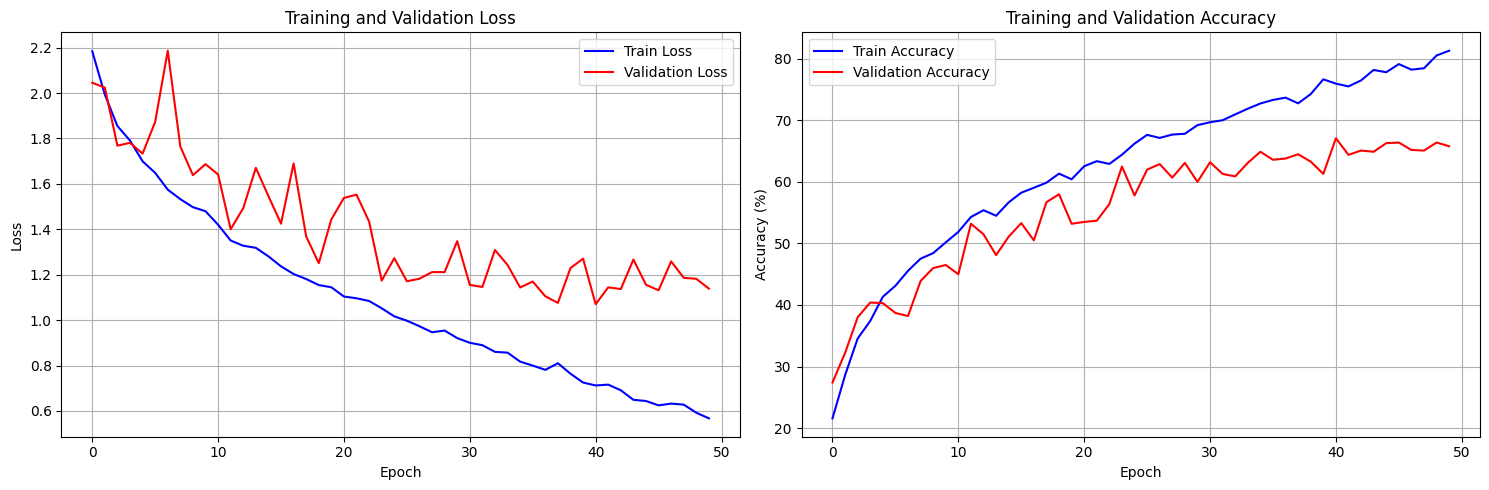

In [17]:
model = ResultResNet(num_classes=10)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history_ResNet = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=50,
    path_model= 'result_model_t3.pth'
)

plot_training_history(history_ResNet)

**Вывод**: в результате использования аугментации удалось повысить точность модели. На 41 эпохе достигнута точность 67.10%.

# Часть 2. Базовая U-Net на "Луне"

## Инициализация данных

In [229]:
class MoonSegmentationDataset(Dataset):

    def __init__(self, root_dir, image_folder='render', mask_folder='ground', 
                 image_ids=None, augmentation=None, preprocessing=None):
        self.root_dir = root_dir
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
        images_dir = os.path.join(root_dir, 'images', image_folder)
        masks_dir = os.path.join(root_dir, 'images', mask_folder)
        
        if image_ids is None:
            all_images = os.listdir(images_dir)
            self.image_ids = [img.replace('.png', '') for img in all_images if img.endswith('.png')]
        else:
            self.image_ids = image_ids
        
    
    def __len__(self):
        return len(self.image_ids)
    
    # что будем делать над элементами датасета
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        
        image_path = os.path.join(self.root_dir, 'images', self.image_folder, f"{image_id}.png")
        
        # Для масок убираем префикс "render" если он есть
        # Например: render0001 - 0001
        mask_id = image_id.replace('render', '') if 'render' in image_id else image_id
        mask_path = os.path.join(self.root_dir, 'images', self.mask_folder, f"ground{mask_id}.png")
        
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) 
        
        # Так как используем opencv, то не забываем преводить из BGR в RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Нормализуем бинарную маску к [0, 1]
        # 0 = фон, 1 = камни
        mask = (mask > 0).astype(np.float32) # можно было бы просто поделить на 255
        
        # Применяем аугментации
        # необходимо делать одинаковую аугментацию на изображение и на маску 
        # в противном случае не будет коореляции между ними  

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # Применяем предобработку
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return image, mask


## Создание аугментаций с Albumentations

In [271]:
# Аугментации для обучения
train_augmentation = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0)),
        A.GaussianBlur(blur_limit=(3, 7)),
        A.MedianBlur(blur_limit=5),
    ], p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
])

preprocessing = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_augmentation = A.Compose([
    A.Resize(128, 128),
])


## Разделение данных на обучающую и валидационную выборки

In [296]:
DATA_ROOT = 'MOON_SEGMENTATION_BINARY'


images_dir = os.path.join(DATA_ROOT, 'images', 'render')
all_images = [img.replace('.png', '') for img in os.listdir(images_dir) if img.endswith('.png')][:100]

print(f"Всего изображений: {len(all_images)}")

train_ids, val_ids = train_test_split(all_images, test_size=0.2, random_state=42)

print(f"Train: {len(train_ids)} изображений")
print(f"Val: {len(val_ids)} изображений")

train_dataset = MoonSegmentationDataset(
    root_dir=DATA_ROOT,
    image_folder='render',
    mask_folder='ground',
    image_ids=train_ids,
    augmentation=train_augmentation,
    preprocessing=preprocessing
)

val_dataset = MoonSegmentationDataset(
    root_dir=DATA_ROOT,
    image_folder='render',
    mask_folder='ground',
    image_ids=val_ids,
    augmentation=val_augmentation,
    preprocessing=preprocessing
)

BATCH_SIZE = 4
NUM_WORKERS = 0

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Батчей в train: {len(train_loader)}")
print(f"Батчей в val: {len(val_loader)}")

Всего изображений: 100
Train: 80 изображений
Val: 20 изображений
Батчей в train: 20
Батчей в val: 5


## Архитектура U-Net

### Основные компоненты:
1. **Encoder (Downsampling)** - сжимает изображение, извлекая признаки
2. **Bottleneck** - самый глубокий слой с максимальным количеством каналов
3. **Decoder (Upsampling)** - восстанавливает разрешение
4. **Skip Connections** - соединяют encoder и decoder для сохранения деталей

In [297]:
# Используем одну всертку вместо 2-х для уменьшения количетсва параметров
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

In [298]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        
        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        prev_channels = in_channels
        for feature in features:
            self.encoder_blocks.append(Conv(prev_channels, feature))
            prev_channels = feature
            

        self.bottleneck = Conv(features[-1], features[-1] * 2)

        in_channels = features[-1] * 2
        for feature in reversed(features):

            self.decoder_blocks.append(
                nn.ConvTranspose2d(in_channels, feature, kernel_size=2, stride=2)
            )
            self.decoder_blocks.append(
                Conv(feature * 2, feature)
            )
            in_channels = feature

        self.final_conv = nn.Sequential(nn.Conv2d(features[0], out_channels, kernel_size=1),
                                        nn.Sigmoid())
        
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Параметров: {total_params:,}")
        print(f"Уровней encoder: {len(features)}")
        print(f"Конфигурация каналов: {features}")
    
    def forward(self, x):

        skip_connections = []

        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[idx](x)
            
            skip_connection = skip_connections[idx // 2]
            
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], 
                                mode='bilinear', align_corners=True)
            
            x = torch.cat([skip_connection, x], dim=1)
            
            x = self.decoder_blocks[idx + 1](x)

        output = self.final_conv(x)
        
        return output

# для выполнения требуемых условий (2.5М параметров) было уменьшено количетсво каналов на последнем уровне
model = UNet(in_channels=3, out_channels=1, features=[32, 64, 128, 192])

test_input = torch.randn(1, 3, 128, 128)
test_output = model(test_input)

print(f"   Вход:  {test_input.shape}")
print(f"   Выход: {test_output.shape}")

Параметров: 2,466,657
Уровней encoder: 4
Конфигурация каналов: [32, 64, 128, 192]
   Вход:  torch.Size([1, 3, 128, 128])
   Выход: torch.Size([1, 1, 128, 128])


## Функции потерь и метрики для сегментации

### Метрики сегментации:
- **Dice Loss** - популярная функция потерь для сегментации
- **IoU (Intersection over Union)** - метрика качества сегментации
- **Pixel Accuracy** - точность предсказания пикселей

In [299]:
class DiceLoss(nn.Module):
    """
    Dice Loss для бинарной сегментации
    
    Dice = 2 * |X ∩ Y| / (|X| + |Y|)
    """
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, predictions, targets):

        # Flatten
        predictions = predictions.view(-1)
        targets = targets.view(-1)
        
        # Dice coefficient
        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)
        
        # Dice loss
        return 1 - dice

class CombinedLoss(nn.Module):

    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
    
    def forward(self, predictions, targets):
        bce_loss = self.bce(predictions, targets)
        dice_loss = self.dice(predictions, targets)
        
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss


def dice_coefficient(predictions, targets, threshold=0.5, smooth=1e-6):

    predictions = (predictions > threshold).float()
    
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    
    intersection = (predictions * targets).sum()
    dice = (2. * intersection + smooth) / (predictions.sum() + targets.sum() + smooth)
    
    return dice.item()


def iou_score(predictions, targets, threshold=0.5, smooth=1e-6):

    predictions = (predictions > threshold).float()
    
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    
    intersection = (predictions * targets).sum()
    union = predictions.sum() + targets.sum() - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    
    return iou.item()


def pixel_accuracy(predictions, targets, threshold=0.5):

    predictions = (predictions > threshold).float()
    correct = (predictions == targets).float().sum()
    total = targets.numel()
    
    return (correct / total).item()



## Цикл обучения

In [300]:
def train_epoch(model, train_loader, criterion, optimizer, device):

    model.train()
    
    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    
    pbar = tqdm(train_loader, desc="Training")
    
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, masks)
        
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)
        
        running_loss += loss.item()
        running_dice += dice
        running_iou += iou
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{dice:.4f}',
            'iou': f'{iou:.4f}'
        })
    
    avg_loss = running_loss / len(train_loader)
    avg_dice = running_dice / len(train_loader)
    avg_iou = running_iou / len(train_loader)
    
    return avg_loss, avg_dice, avg_iou

In [301]:
def validate_epoch(model, val_loader, criterion, device):

    model.eval()
    
    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    running_acc = 0.0
    
    pbar = tqdm(val_loader, desc="Validation")
    
    with torch.no_grad():
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.unsqueeze(1).to(device)
            
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            
            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)
            acc = pixel_accuracy(outputs, masks)
            
            running_loss += loss.item()
            running_dice += dice
            running_iou += iou
            running_acc += acc
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice:.4f}',
                'iou': f'{iou:.4f}',
                'acc': f'{acc:.4f}'
            })
    
    avg_loss = running_loss / len(val_loader)
    avg_dice = running_dice / len(val_loader)
    avg_iou = running_iou / len(val_loader)
    avg_acc = running_acc / len(val_loader)
    
    return avg_loss, avg_dice, avg_iou, avg_acc

In [302]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20, save_path='best_unet.pth'):

    model = model.to(device)
    
    history = {
        'train_loss': [],
        'train_dice': [],
        'train_iou': [],
        'val_loss': [],
        'val_dice': [],
        'val_iou': [],
        'val_acc': [],
        'lr': []
    }
    
    best_val_dice = 0.0
    
    for epoch in range(num_epochs):
        print(f"Эпоха {epoch+1}/{num_epochs}")
        
        # Здесь происходит основное обучение
        train_loss, train_dice, train_iou = train_epoch(
            model, train_loader, criterion, optimizer, device
        )
        
        # Валидация 
        val_loss, val_dice, val_iou, val_acc = validate_epoch(
            model, val_loader, criterion, device
        )
        
        # Обновляем learning rate (проверяем на )
        if scheduler is not None:
            scheduler.step(val_dice)
            current_lr = optimizer.param_groups[0]['lr']
        else:
            current_lr = optimizer.param_groups[0]['lr']
        
        # Сохраняем всю нашу историю
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        
        # Выводим результаты
        print(f"\n Результаты эпохи {epoch+1}:")
        print(f"  Train - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}, Acc: {val_acc:.4f}")
        print(f"  LR: {current_lr:.6f}")
        
        # Сохраняем лучшую модел, можно сохранять по метрике или loss (лучше по ней)
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': val_dice,
                'val_iou': val_iou,
            }, save_path)
            print(f"  Сохранена лучшая модель! Dice: {val_dice:.4f}")
    
    print(f"Лучший Val Dice: {best_val_dice:.4f}") 
    
    return history

In [303]:
def plot_training_history_2(history):

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 15))

    ax1.plot(history['lr'], label='Learning Rate', color='purple', marker = 'o')
    ax1.set_title('Learning Rate')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('LR')
    ax1.set_yscale('log')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['train_loss'], label='Train Loss', color='blue', marker = 'o')
    ax2.plot(history['val_loss'], label='Validation Loss', color='red', marker = 'o')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    ax3.plot(history['train_dice'], label='Train Dice', color='blue', marker = 'o')
    ax3.plot(history['val_dice'], label='Validation Dice', color='red', marker = 'o')
    ax3.set_title('Training and Validation Dice')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Dice')
    ax3.legend()
    ax3.grid(True)

    ax4.plot(history['train_iou'], label='Train IoU', color='blue', marker = 'o')
    ax4.plot(history['val_iou'], label='Validation IoU', color='red', marker = 'o')
    ax4.set_title('Training and Validation IoU')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('IoU')
    ax4.legend()
    ax4.grid(True)

    plt.suptitle('History of learning UNet')
    plt.tight_layout()
    plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"  Используем устройство: {device}")
model = UNet(in_channels=3, 
            out_channels=1, 
            features=[32, 64, 128, 192])
criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=1e-4, 
                             weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='max',
                                                       factor=0.5,
                                                       patience=3,)

history_unet = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=50,
    save_path='best_moon_unet.pth'
)

  Используем устройство: cpu
Параметров: 2,466,657
Уровней encoder: 4
Конфигурация каналов: [32, 64, 128, 192]
Эпоха 1/50


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation: 100%|██████████| 5/5 [00:00<00:00,  7.88it/s, loss=0.8679, dice=0.1409, iou=0.0758, acc=0.9077]



 Результаты эпохи 1:
  Train - Loss: 0.8606, Dice: 0.2353, IoU: 0.1364
  Val   - Loss: 0.8622, Dice: 0.1648, IoU: 0.0903, Acc: 0.8974
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.1648
Эпоха 2/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.05it/s, loss=0.8282, dice=0.4047, iou=0.2537, acc=0.8400]



 Результаты эпохи 2:
  Train - Loss: 0.8293, Dice: 0.3396, IoU: 0.2078
  Val   - Loss: 0.8228, Dice: 0.3973, IoU: 0.2491, Acc: 0.8202
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3973
Эпоха 3/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.04it/s, loss=0.8109, dice=0.3899, iou=0.2422, acc=0.7803]



 Результаты эпохи 3:
  Train - Loss: 0.8201, Dice: 0.3410, IoU: 0.2102
  Val   - Loss: 0.8123, Dice: 0.3709, IoU: 0.2295, Acc: 0.7550
  LR: 0.000100
Эпоха 4/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.15it/s, loss=0.7873, dice=0.4375, iou=0.2800, acc=0.8666]



 Результаты эпохи 4:
  Train - Loss: 0.8170, Dice: 0.3510, IoU: 0.2178
  Val   - Loss: 0.7905, Dice: 0.4100, IoU: 0.2583, Acc: 0.8269
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4100
Эпоха 5/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.27it/s, loss=0.7937, dice=0.4203, iou=0.2661, acc=0.8903]



 Результаты эпохи 5:
  Train - Loss: 0.8104, Dice: 0.3548, IoU: 0.2201
  Val   - Loss: 0.7911, Dice: 0.4108, IoU: 0.2604, Acc: 0.8713
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4108
Эпоха 6/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.15it/s, loss=0.7967, dice=0.3835, iou=0.2373, acc=0.8952]



 Результаты эпохи 6:
  Train - Loss: 0.8013, Dice: 0.3855, IoU: 0.2431
  Val   - Loss: 0.7889, Dice: 0.4094, IoU: 0.2590, Acc: 0.8637
  LR: 0.000100
Эпоха 7/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.32it/s, loss=0.8079, dice=0.3769, iou=0.2322, acc=0.7725]



 Результаты эпохи 7:
  Train - Loss: 0.8020, Dice: 0.3748, IoU: 0.2353
  Val   - Loss: 0.8022, Dice: 0.3754, IoU: 0.2337, Acc: 0.7568
  LR: 0.000100
Эпоха 8/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.34it/s, loss=0.7871, dice=0.3713, iou=0.2280, acc=0.8917]



 Результаты эпохи 8:
  Train - Loss: 0.7958, Dice: 0.3952, IoU: 0.2492
  Val   - Loss: 0.7785, Dice: 0.4081, IoU: 0.2589, Acc: 0.8637
  LR: 0.000100
Эпоха 9/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.31it/s, loss=0.7927, dice=0.4163, iou=0.2628, acc=0.8150]



 Результаты эпохи 9:
  Train - Loss: 0.7939, Dice: 0.3929, IoU: 0.2502
  Val   - Loss: 0.7927, Dice: 0.3934, IoU: 0.2468, Acc: 0.7825
  LR: 0.000050
Эпоха 10/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.10it/s, loss=0.7728, dice=0.4756, iou=0.3120, acc=0.8798]



 Результаты эпохи 10:
  Train - Loss: 0.7895, Dice: 0.4061, IoU: 0.2597
  Val   - Loss: 0.7706, Dice: 0.4600, IoU: 0.3017, Acc: 0.8603
  LR: 0.000050
  Сохранена лучшая модель! Dice: 0.4600
Эпоха 11/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.87it/s, loss=0.7785, dice=0.4345, iou=0.2776, acc=0.8494]



 Результаты эпохи 11:
  Train - Loss: 0.7869, Dice: 0.4137, IoU: 0.2657
  Val   - Loss: 0.7774, Dice: 0.4290, IoU: 0.2754, Acc: 0.8309
  LR: 0.000050
Эпоха 12/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.40it/s, loss=0.7749, dice=0.4643, iou=0.3023, acc=0.8762]



 Результаты эпохи 12:
  Train - Loss: 0.7827, Dice: 0.4168, IoU: 0.2703
  Val   - Loss: 0.7704, Dice: 0.4675, IoU: 0.3081, Acc: 0.8657
  LR: 0.000050
  Сохранена лучшая модель! Dice: 0.4675
Эпоха 13/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.36it/s, loss=0.7685, dice=0.4586, iou=0.2975, acc=0.8770]



 Результаты эпохи 13:
  Train - Loss: 0.7868, Dice: 0.4092, IoU: 0.2611
  Val   - Loss: 0.7664, Dice: 0.4542, IoU: 0.2970, Acc: 0.8624
  LR: 0.000050
Эпоха 14/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.23it/s, loss=0.7666, dice=0.4705, iou=0.3076, acc=0.9041]



 Результаты эпохи 14:
  Train - Loss: 0.7786, Dice: 0.4320, IoU: 0.2809
  Val   - Loss: 0.7639, Dice: 0.4581, IoU: 0.3011, Acc: 0.8815
  LR: 0.000050
Эпоха 15/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.16it/s, loss=0.7658, dice=0.4566, iou=0.2958, acc=0.8829]



 Результаты эпохи 15:
  Train - Loss: 0.7797, Dice: 0.4191, IoU: 0.2683
  Val   - Loss: 0.7631, Dice: 0.4542, IoU: 0.2969, Acc: 0.8784
  LR: 0.000050
Эпоха 16/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.21it/s, loss=0.7646, dice=0.4767, iou=0.3129, acc=0.8804]



 Результаты эпохи 16:
  Train - Loss: 0.7779, Dice: 0.4240, IoU: 0.2759
  Val   - Loss: 0.7637, Dice: 0.4558, IoU: 0.2979, Acc: 0.8576
  LR: 0.000025
Эпоха 17/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.40it/s, loss=0.7650, dice=0.4656, iou=0.3034, acc=0.9050]



 Результаты эпохи 17:
  Train - Loss: 0.7785, Dice: 0.4189, IoU: 0.2673
  Val   - Loss: 0.7579, Dice: 0.4681, IoU: 0.3093, Acc: 0.8869
  LR: 0.000025
  Сохранена лучшая модель! Dice: 0.4681
Эпоха 18/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.28it/s, loss=0.7690, dice=0.4598, iou=0.2985, acc=0.8491]



 Результаты эпохи 18:
  Train - Loss: 0.7726, Dice: 0.4469, IoU: 0.2905
  Val   - Loss: 0.7709, Dice: 0.4351, IoU: 0.2801, Acc: 0.8236
  LR: 0.000025
Эпоха 19/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.34it/s, loss=0.7624, dice=0.4797, iou=0.3156, acc=0.8694]



 Результаты эпохи 19:
  Train - Loss: 0.7711, Dice: 0.4473, IoU: 0.2931
  Val   - Loss: 0.7612, Dice: 0.4678, IoU: 0.3083, Acc: 0.8570
  LR: 0.000025
Эпоха 20/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.44it/s, loss=0.7584, dice=0.4975, iou=0.3311, acc=0.8950]



 Результаты эпохи 20:
  Train - Loss: 0.7720, Dice: 0.4443, IoU: 0.2924
  Val   - Loss: 0.7559, Dice: 0.4870, IoU: 0.3254, Acc: 0.8832
  LR: 0.000025
  Сохранена лучшая модель! Dice: 0.4870
Эпоха 21/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.76it/s, loss=0.7608, dice=0.4780, iou=0.3141, acc=0.8728]



 Результаты эпохи 21:
  Train - Loss: 0.7697, Dice: 0.4455, IoU: 0.2938
  Val   - Loss: 0.7590, Dice: 0.4699, IoU: 0.3106, Acc: 0.8610
  LR: 0.000025
Эпоха 22/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.21it/s, loss=0.7612, dice=0.4817, iou=0.3172, acc=0.8816]



 Результаты эпохи 22:
  Train - Loss: 0.7737, Dice: 0.4354, IoU: 0.2833
  Val   - Loss: 0.7582, Dice: 0.4715, IoU: 0.3118, Acc: 0.8646
  LR: 0.000025
Эпоха 23/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.34it/s, loss=0.7619, dice=0.4694, iou=0.3067, acc=0.8633]



 Результаты эпохи 23:
  Train - Loss: 0.7758, Dice: 0.4183, IoU: 0.2714
  Val   - Loss: 0.7617, Dice: 0.4578, IoU: 0.3004, Acc: 0.8499
  LR: 0.000025
Эпоха 24/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.61it/s, loss=0.7616, dice=0.4856, iou=0.3206, acc=0.8884]



 Результаты эпохи 24:
  Train - Loss: 0.7724, Dice: 0.4336, IoU: 0.2843
  Val   - Loss: 0.7579, Dice: 0.4788, IoU: 0.3186, Acc: 0.8761
  LR: 0.000013
Эпоха 25/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.15it/s, loss=0.7598, dice=0.4794, iou=0.3152, acc=0.8744]



 Результаты эпохи 25:
  Train - Loss: 0.7670, Dice: 0.4501, IoU: 0.2956
  Val   - Loss: 0.7608, Dice: 0.4575, IoU: 0.3000, Acc: 0.8514
  LR: 0.000013
Эпоха 26/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.55it/s, loss=0.7630, dice=0.4717, iou=0.3086, acc=0.8650]



 Результаты эпохи 26:
  Train - Loss: 0.7664, Dice: 0.4497, IoU: 0.2964
  Val   - Loss: 0.7616, Dice: 0.4594, IoU: 0.3015, Acc: 0.8484
  LR: 0.000013
Эпоха 27/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.91it/s, loss=0.7572, dice=0.4907, iou=0.3251, acc=0.8907]



 Результаты эпохи 27:
  Train - Loss: 0.7716, Dice: 0.4389, IoU: 0.2880
  Val   - Loss: 0.7533, Dice: 0.4813, IoU: 0.3207, Acc: 0.8743
  LR: 0.000013
Эпоха 28/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.21it/s, loss=0.7603, dice=0.4758, iou=0.3122, acc=0.8704]



 Результаты эпохи 28:
  Train - Loss: 0.7695, Dice: 0.4431, IoU: 0.2943
  Val   - Loss: 0.7578, Dice: 0.4656, IoU: 0.3069, Acc: 0.8542
  LR: 0.000006
Эпоха 29/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.40it/s, loss=0.7580, dice=0.4875, iou=0.3223, acc=0.8842]



 Результаты эпохи 29:
  Train - Loss: 0.7643, Dice: 0.4535, IoU: 0.2988
  Val   - Loss: 0.7562, Dice: 0.4727, IoU: 0.3132, Acc: 0.8651
  LR: 0.000006
Эпоха 30/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.43it/s, loss=0.7594, dice=0.4757, iou=0.3121, acc=0.8673]



 Результаты эпохи 30:
  Train - Loss: 0.7662, Dice: 0.4524, IoU: 0.2972
  Val   - Loss: 0.7594, Dice: 0.4611, IoU: 0.3029, Acc: 0.8508
  LR: 0.000006
Эпоха 31/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.71it/s, loss=0.7590, dice=0.4902, iou=0.3247, acc=0.8840]



 Результаты эпохи 31:
  Train - Loss: 0.7661, Dice: 0.4508, IoU: 0.2972
  Val   - Loss: 0.7572, Dice: 0.4749, IoU: 0.3150, Acc: 0.8670
  LR: 0.000006
Эпоха 32/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.31it/s, loss=0.7574, dice=0.4883, iou=0.3231, acc=0.8744]



 Результаты эпохи 32:
  Train - Loss: 0.7622, Dice: 0.4619, IoU: 0.3042
  Val   - Loss: 0.7571, Dice: 0.4709, IoU: 0.3115, Acc: 0.8573
  LR: 0.000003
Эпоха 33/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.29it/s, loss=0.7588, dice=0.4767, iou=0.3129, acc=0.8662]



 Результаты эпохи 33:
  Train - Loss: 0.7664, Dice: 0.4497, IoU: 0.2973
  Val   - Loss: 0.7579, Dice: 0.4658, IoU: 0.3072, Acc: 0.8538
  LR: 0.000003
Эпоха 34/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.08it/s, loss=0.7578, dice=0.4843, iou=0.3195, acc=0.8738]



 Результаты эпохи 34:
  Train - Loss: 0.7678, Dice: 0.4428, IoU: 0.2889
  Val   - Loss: 0.7576, Dice: 0.4688, IoU: 0.3096, Acc: 0.8576
  LR: 0.000003
Эпоха 35/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.53it/s, loss=0.7570, dice=0.4820, iou=0.3175, acc=0.8758]



 Результаты эпохи 35:
  Train - Loss: 0.7688, Dice: 0.4355, IoU: 0.2872
  Val   - Loss: 0.7551, Dice: 0.4720, IoU: 0.3124, Acc: 0.8613
  LR: 0.000003
Эпоха 36/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.95it/s, loss=0.7530, dice=0.4879, iou=0.3227, acc=0.8776]



 Результаты эпохи 36:
  Train - Loss: 0.7646, Dice: 0.4576, IoU: 0.3012
  Val   - Loss: 0.7538, Dice: 0.4692, IoU: 0.3100, Acc: 0.8593
  LR: 0.000002
Эпоха 37/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.83it/s, loss=0.7544, dice=0.4937, iou=0.3277, acc=0.8805]



 Результаты эпохи 37:
  Train - Loss: 0.7578, Dice: 0.4745, IoU: 0.3160
  Val   - Loss: 0.7546, Dice: 0.4736, IoU: 0.3137, Acc: 0.8610
  LR: 0.000002
Эпоха 38/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.05it/s, loss=0.7562, dice=0.4853, iou=0.3204, acc=0.8730]



 Результаты эпохи 38:
  Train - Loss: 0.7635, Dice: 0.4543, IoU: 0.3005
  Val   - Loss: 0.7562, Dice: 0.4695, IoU: 0.3102, Acc: 0.8570
  LR: 0.000002
Эпоха 39/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.24it/s, loss=0.7540, dice=0.4953, iou=0.3291, acc=0.8810]



 Результаты эпохи 39:
  Train - Loss: 0.7723, Dice: 0.4189, IoU: 0.2728
  Val   - Loss: 0.7541, Dice: 0.4768, IoU: 0.3165, Acc: 0.8644
  LR: 0.000002
Эпоха 40/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.77it/s, loss=0.7552, dice=0.4897, iou=0.3242, acc=0.8782]



 Результаты эпохи 40:
  Train - Loss: 0.7663, Dice: 0.4409, IoU: 0.2891
  Val   - Loss: 0.7551, Dice: 0.4733, IoU: 0.3135, Acc: 0.8614
  LR: 0.000001
Эпоха 41/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.25it/s, loss=0.7531, dice=0.4888, iou=0.3234, acc=0.8772]



 Результаты эпохи 41:
  Train - Loss: 0.7645, Dice: 0.4529, IoU: 0.2970
  Val   - Loss: 0.7534, Dice: 0.4711, IoU: 0.3115, Acc: 0.8592
  LR: 0.000001
Эпоха 42/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.65it/s, loss=0.7552, dice=0.4964, iou=0.3301, acc=0.8841]



 Результаты эпохи 42:
  Train - Loss: 0.7643, Dice: 0.4532, IoU: 0.2980
  Val   - Loss: 0.7548, Dice: 0.4778, IoU: 0.3175, Acc: 0.8665
  LR: 0.000001
Эпоха 43/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.79it/s, loss=0.7548, dice=0.5007, iou=0.3339, acc=0.8890]



 Результаты эпохи 43:
  Train - Loss: 0.7654, Dice: 0.4429, IoU: 0.2926
  Val   - Loss: 0.7532, Dice: 0.4823, IoU: 0.3215, Acc: 0.8719
  LR: 0.000001
Эпоха 44/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.83it/s, loss=0.7565, dice=0.4812, iou=0.3168, acc=0.8711]



 Результаты эпохи 44:
  Train - Loss: 0.7582, Dice: 0.4687, IoU: 0.3126
  Val   - Loss: 0.7554, Dice: 0.4686, IoU: 0.3095, Acc: 0.8565
  LR: 0.000000
Эпоха 45/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.32it/s, loss=0.7525, dice=0.5044, iou=0.3373, acc=0.8925]



 Результаты эпохи 45:
  Train - Loss: 0.7640, Dice: 0.4534, IoU: 0.2995
  Val   - Loss: 0.7520, Dice: 0.4810, IoU: 0.3205, Acc: 0.8719
  LR: 0.000000
Эпоха 46/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.11it/s, loss=0.7538, dice=0.4883, iou=0.3230, acc=0.8774]



 Результаты эпохи 46:
  Train - Loss: 0.7619, Dice: 0.4577, IoU: 0.3036
  Val   - Loss: 0.7539, Dice: 0.4711, IoU: 0.3116, Acc: 0.8592
  LR: 0.000000
Эпоха 47/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.21it/s, loss=0.7570, dice=0.4849, iou=0.3201, acc=0.8697]



 Результаты эпохи 47:
  Train - Loss: 0.7681, Dice: 0.4432, IoU: 0.2908
  Val   - Loss: 0.7573, Dice: 0.4665, IoU: 0.3076, Acc: 0.8521
  LR: 0.000000
Эпоха 48/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.11it/s, loss=0.7576, dice=0.4830, iou=0.3183, acc=0.8762]



 Результаты эпохи 48:
  Train - Loss: 0.7648, Dice: 0.4502, IoU: 0.2970
  Val   - Loss: 0.7558, Dice: 0.4727, IoU: 0.3131, Acc: 0.8621
  LR: 0.000000
Эпоха 49/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.35it/s, loss=0.7557, dice=0.4901, iou=0.3246, acc=0.8787]



 Результаты эпохи 49:
  Train - Loss: 0.7622, Dice: 0.4616, IoU: 0.3058
  Val   - Loss: 0.7549, Dice: 0.4749, IoU: 0.3149, Acc: 0.8629
  LR: 0.000000
Эпоха 50/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.94it/s, loss=0.7543, dice=0.4939, iou=0.3280, acc=0.8796]


 Результаты эпохи 50:
  Train - Loss: 0.7644, Dice: 0.4558, IoU: 0.2994
  Val   - Loss: 0.7552, Dice: 0.4730, IoU: 0.3133, Acc: 0.8610
  LR: 0.000000
Лучший Val Dice: 0.4870


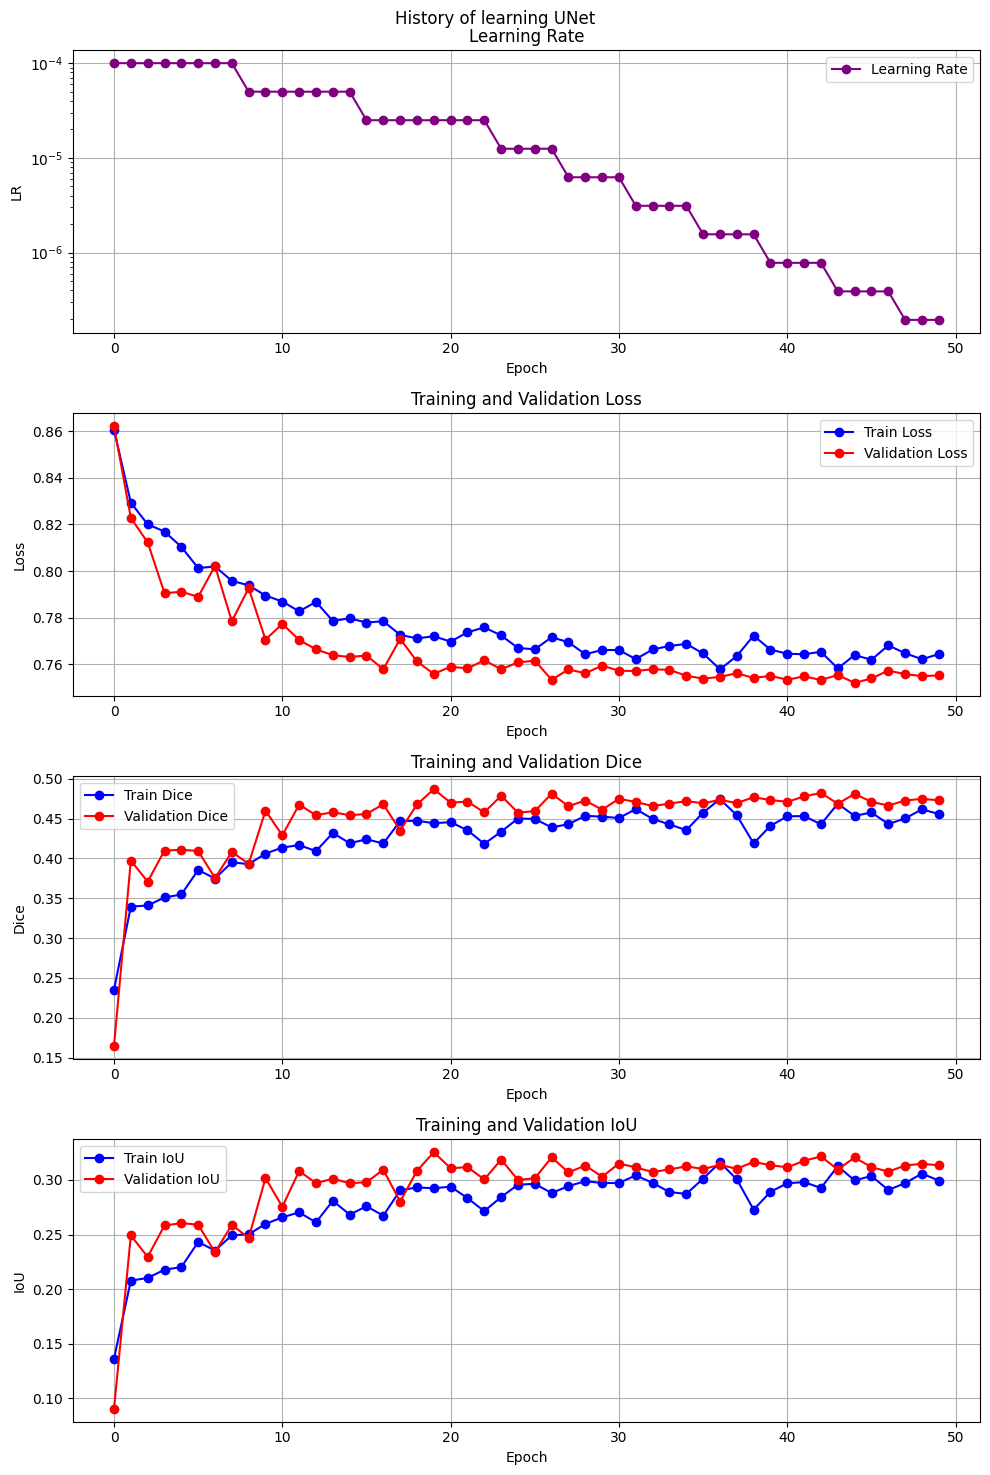

In [305]:
plot_training_history_2(history_unet)

In [306]:
max_val_dice = max(history_unet['val_dice'])
idx = history_unet['val_dice'].index(max_val_dice)
train_dice = history_unet['train_dice'][idx]

train_loss = history_unet['train_loss'][idx]
val_loss = history_unet['val_loss'][idx]

train_iou = history_unet['train_iou'][idx]
val_iou = history_unet['val_iou'][idx]

val_acc = history_unet['val_acc'][idx]

print('Лучший результат:')
print(f'Epoch      : {idx+1}')
print(f'Train dice : {train_dice:.4f}')
print(f'Val dice   : {max_val_dice:.4f}')
print(f'Train loss : {train_loss:.4f}')
print(f'Val loss   : {val_loss:.4f}')
print(f'Train IoU  : {train_iou:.4f}')
print(f'Val IoU    : {val_iou:.4f}')
print(f'Val Acc    : {val_acc}')

Лучший результат:
Epoch      : 20
Train dice : 0.4443
Val dice   : 0.4870
Train loss : 0.7720
Val loss   : 0.7559
Train IoU  : 0.2924
Val IoU    : 0.3254
Val Acc    : 0.8831512451171875


In [307]:
df_results = pd.DataFrame({'model' : [],
                            'Количество параметров' : [],
                            'Кол-во эпох' : [],
                            'Train Dice' : [],
                            'Val Dice': [],
                            'Train Loss' : [],
                            'Val Loss': [],
                            'Train IoU' : [],
                            'Val IoU' : [],
                            'Val Acc' : [],
                            'Эпоха по макс Val Dice' : []})

params = f'{sum(p.numel() for p in model.parameters())/1000000:.2f}M'
epoch = len(history_unet['val_dice'])

max_val_dice = max(history_unet['val_dice'])
idx = history_unet['val_dice'].index(max_val_dice)

train_dice = history_unet['train_dice'][idx]

train_loss = history_unet['train_loss'][idx]
val_loss = history_unet['val_loss'][idx]

train_iou = history_unet['train_iou'][idx]
val_iou = history_unet['val_iou'][idx]

val_acc = history_unet['val_acc'][idx]

df_results.loc[len(df_results)] = ['Base UNet', params , epoch, train_dice, max_val_dice, train_loss, val_loss, train_iou, val_iou, val_acc, idx + 1]
df_results.head()

model Количество параметров  Кол-во эпох  Train Dice  Val Dice  \
0  Base UNet                 2.47M           50    0.444274  0.486969   

   Train Loss  Val Loss  Train IoU  Val IoU   Val Acc  Эпоха по макс Val Dice  
0    0.772027  0.755854    0.29236   0.3254  0.883151                      20

## Визуализация предсказаний модели

In [308]:
def denormalize(img_tensor):
    """Денормализация изображения для визуализации"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)


In [309]:
def visualize_predictions(model, dataloader, device, num_samples=4):

    model.eval()
    model.to(device)
    images_list = []
    masks_list = []
    
    for images, masks in dataloader:
        images_list.append(images)
        masks_list.append(masks)
        if sum(len(b) for b in images_list) >= num_samples:
            break
    
    images = torch.cat(images_list, dim = 0)[:num_samples]
    masks = torch.cat(masks_list, dim = 0)[:num_samples]

    images = images.to(device)
    masks = masks.to(device)
    
    with torch.no_grad():
        predictions = model(images)
        predictions = (predictions > 0.5).float()

    images = images.cpu()
    masks = masks.cpu()
    predictions = predictions.cpu()
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    if min(num_samples, len(images)) == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(min(num_samples, len(images))):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        mask_true = masks[i, :,:].numpy()
        mask_pred = predictions[i, 0].numpy()
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Исходное изображение', fontsize=12)
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask_true, cmap='gray')
        axes[i, 1].set_title('Истинная маска', fontsize=12)
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(mask_pred, cmap='gray')
        axes[i, 2].set_title('Предсказание', fontsize=12)
        axes[i, 2].axis('off')
        
        overlay = img.copy()
        overlay[mask_pred > 0.5] = [0, 1, 0]
        
        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title('Наложение', fontsize=12)
        axes[i, 3].axis('off')
        
        dice = dice_coefficient(predictions[i:i+1], masks[i:i+1])
        iou = iou_score(predictions[i:i+1], masks[i:i+1])
        
        axes[i, 3].text(0.5, -0.15, 
                        f'Dice: {dice:.4f} | IoU: {iou:.4f}',
                        ha='center', va='top', transform=axes[i, 3].transAxes,
                        fontsize=10, fontweight='bold', color='blue')
    
    plt.suptitle('Предсказания модели U-Net', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

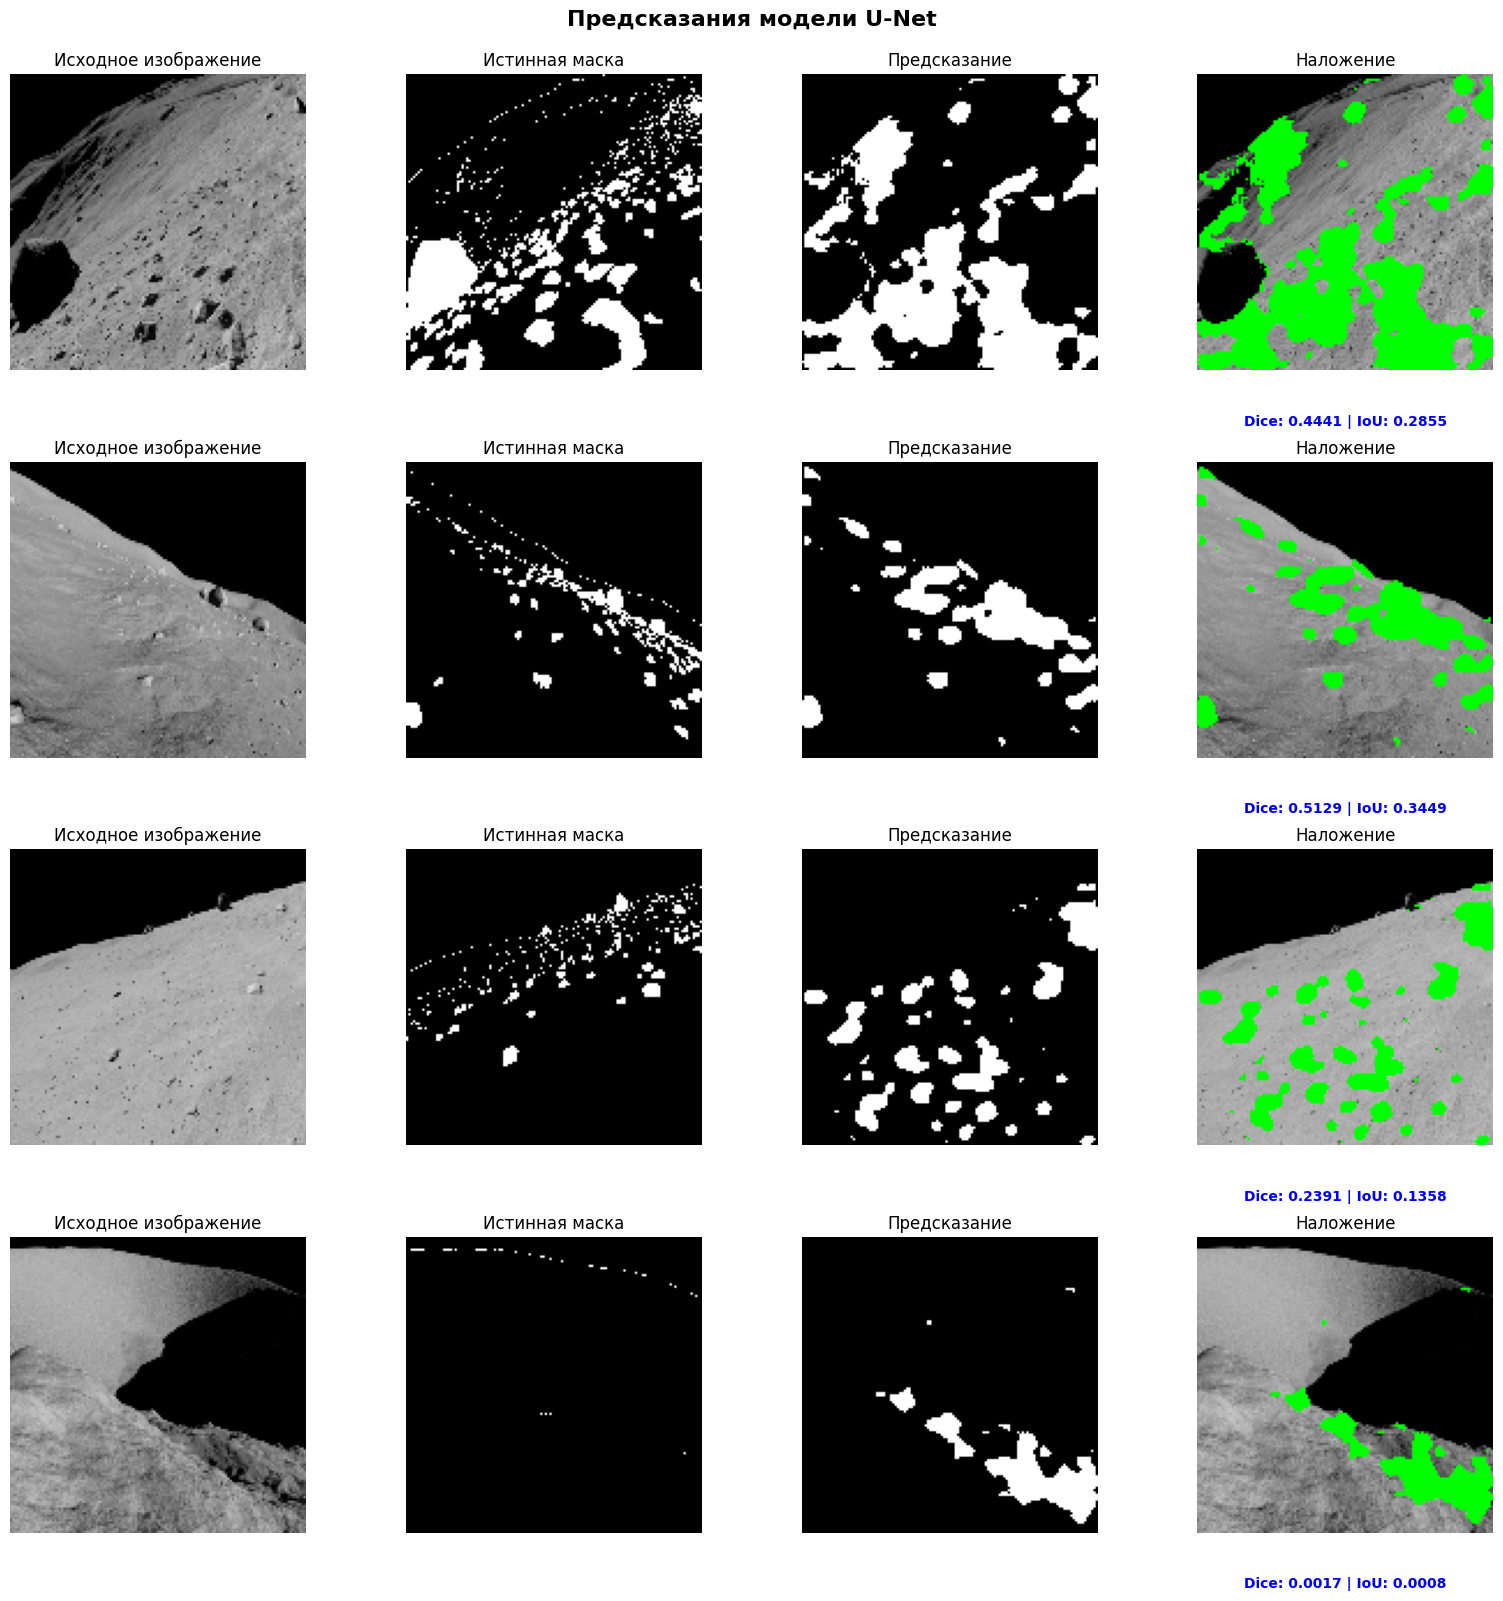

In [310]:
visualize_predictions(model, val_loader, device, num_samples=4)

# Часть 3. U-Net с бэкбоном из классификатора

## Вариант A (заморозка): заморозить веса энкодера, обучать только декодер.

In [319]:
class ResNetUNet_A(nn.Module):

    def __init__(self, out_channels=1, features=[32, 64, 128, 256], state_dict=None):
        super(ResNetUNet_A, self).__init__()

        resnet = ResultResNet()
        resnet.load_state_dict(state_dict)

        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_blocks.append(nn.Sequential(resnet.basic_block_1_1, resnet.basic_block_1_2)) #32 канала
        self.encoder_blocks.append(nn.Sequential(resnet.basic_block_2_1, resnet.basic_block_2_2)) #64 канала
        self.encoder_blocks.append(nn.Sequential(resnet.basic_block_3_1, resnet.basic_block_3_2)) #128 каналов
        self.encoder_blocks.append(nn.Sequential(resnet.basic_block_4_1, resnet.basic_block_4_2)) #256 каналов


        self.bottleneck = Conv(features[-1], features[-1] * 2)

        in_channels = features[-1] * 2
        for feature in reversed(features):
            self.decoder_blocks.append(
                nn.ConvTranspose2d(in_channels, feature, kernel_size=2, stride=2)
            )
            self.decoder_blocks.append(
                Conv(feature * 2, feature)
            )
            in_channels = feature


        self.final_conv = nn.Sequential(
            nn.Conv2d(features[0], out_channels, kernel_size=1),
            nn.Sigmoid())

        total_params = sum(p.numel() for p in self.parameters())
        print(f"Параметров: {total_params:,}")
        print(f"Уровней encoder: {len(features)}")
        print(f"Конфигурация каналов: {features}")

    def forward(self, x):
        skip_connections = []
        for i, encoder_block in enumerate(self.encoder_blocks):
            x = encoder_block(x)
            skip_connections.append(x)
            if i == 0:
             x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:],
                                mode='bilinear', align_corners=True)
            x = torch.cat([skip_connection, x], dim=1)
            x = self.decoder_blocks[idx + 1](x)

        output = self.final_conv(x)
        return output

In [ ]:
ResNet_UNet_A = ResNetUNet_A(out_channels=1, state_dict=torch.load("result_model_t3.pth"))
for param in ResNet_UNet_A.encoder_blocks.parameters():
  param.requires_grad = False

test_input = torch.randn(1, 3, 128, 128)
test_output = ResNet_UNet_A(test_input)

print(f"   Вход:  {test_input.shape}")
print(f"   Выход: {test_output.shape}")

total_params = sum(p.numel() for p in ResNet_UNet_A.parameters())
train_params = sum(p.numel() for p in ResNet_UNet_A.parameters() if p.requires_grad)

print(f"   Всего параметров: {total_params:,}")
print(f"   Обучаемых параметров: {train_params:,}")

Параметров: 6,232,097
Уровней encoder: 4
Конфигурация каналов: [32, 64, 128, 256]
   Вход:  torch.Size([1, 3, 128, 128])
   Выход: torch.Size([1, 1, 128, 128])
   Всего параметров: 6,232,097
   Обучаемых параметров: 3,446,177


In [322]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"  Используем устройство: {device}")
ResNet_UNet_A = ResNetUNet_A(out_channels=1, state_dict=torch.load("result_model_t3.pth"))
for param in ResNet_UNet_A.encoder_blocks.parameters():
  param.requires_grad = False

print(f"   Обучаемых параметров: {sum(p.numel() for p in ResNet_UNet_A.parameters() if p.requires_grad):,}")
criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = torch.optim.Adam(ResNet_UNet_A.parameters(), lr=1e-4, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
)

history_ResNet_UNet_A = train_model(
    model=ResNet_UNet_A,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=50,
    save_path='best_moon_ResNet_UNet_A.pth'
)

  Используем устройство: cpu
Параметров: 6,232,097
Уровней encoder: 4
Конфигурация каналов: [32, 64, 128, 256]
   Обучаемых параметров: 3,446,177
Эпоха 1/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.27it/s, loss=0.8891, dice=0.2016, iou=0.1121, acc=0.3391]



 Результаты эпохи 1:
  Train - Loss: 0.8985, Dice: 0.1941, IoU: 0.1091
  Val   - Loss: 0.8846, Dice: 0.2123, IoU: 0.1199, Acc: 0.3439
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.2123
Эпоха 2/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.25it/s, loss=0.8683, dice=0.2455, iou=0.1399, acc=0.4888]



 Результаты эпохи 2:
  Train - Loss: 0.8752, Dice: 0.2332, IoU: 0.1333
  Val   - Loss: 0.8769, Dice: 0.2405, IoU: 0.1376, Acc: 0.4512
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.2405
Эпоха 3/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.04it/s, loss=0.8440, dice=0.3217, iou=0.1917, acc=0.6947]



 Результаты эпохи 3:
  Train - Loss: 0.8604, Dice: 0.2639, IoU: 0.1544
  Val   - Loss: 0.8557, Dice: 0.2898, IoU: 0.1702, Acc: 0.6042
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.2898
Эпоха 4/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.99it/s, loss=0.8342, dice=0.3575, iou=0.2177, acc=0.7443]



 Результаты эпохи 4:
  Train - Loss: 0.8468, Dice: 0.3039, IoU: 0.1823
  Val   - Loss: 0.8454, Dice: 0.3109, IoU: 0.1848, Acc: 0.6504
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3109
Эпоха 5/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.05it/s, loss=0.8282, dice=0.3893, iou=0.2417, acc=0.7823]



 Результаты эпохи 5:
  Train - Loss: 0.8410, Dice: 0.3193, IoU: 0.1934
  Val   - Loss: 0.8396, Dice: 0.3343, IoU: 0.2016, Acc: 0.6950
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3343
Эпоха 6/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.96it/s, loss=0.8280, dice=0.3823, iou=0.2363, acc=0.7805]



 Результаты эпохи 6:
  Train - Loss: 0.8342, Dice: 0.3332, IoU: 0.2024
  Val   - Loss: 0.8332, Dice: 0.3388, IoU: 0.2049, Acc: 0.7068
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3388
Эпоха 7/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.96it/s, loss=0.8225, dice=0.3900, iou=0.2422, acc=0.7888]



 Результаты эпохи 7:
  Train - Loss: 0.8293, Dice: 0.3404, IoU: 0.2090
  Val   - Loss: 0.8292, Dice: 0.3438, IoU: 0.2085, Acc: 0.7176
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3438
Эпоха 8/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.19it/s, loss=0.8091, dice=0.4202, iou=0.2660, acc=0.8347]



 Результаты эпохи 8:
  Train - Loss: 0.8321, Dice: 0.3213, IoU: 0.1948
  Val   - Loss: 0.8175, Dice: 0.3681, IoU: 0.2267, Acc: 0.7606
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3681
Эпоха 9/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.91it/s, loss=0.8104, dice=0.3953, iou=0.2464, acc=0.8100]



 Результаты эпохи 9:
  Train - Loss: 0.8261, Dice: 0.3400, IoU: 0.2087
  Val   - Loss: 0.8230, Dice: 0.3475, IoU: 0.2112, Acc: 0.7240
  LR: 0.000100
Эпоха 10/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.65it/s, loss=0.8015, dice=0.4183, iou=0.2644, acc=0.8319]



 Результаты эпохи 10:
  Train - Loss: 0.8199, Dice: 0.3530, IoU: 0.2187
  Val   - Loss: 0.8207, Dice: 0.3610, IoU: 0.2210, Acc: 0.7376
  LR: 0.000100
Эпоха 11/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.87it/s, loss=0.8038, dice=0.4146, iou=0.2615, acc=0.8409]



 Результаты эпохи 11:
  Train - Loss: 0.8162, Dice: 0.3612, IoU: 0.2253
  Val   - Loss: 0.8126, Dice: 0.3720, IoU: 0.2295, Acc: 0.7658
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3720
Эпоха 12/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.67it/s, loss=0.8015, dice=0.4214, iou=0.2669, acc=0.8290]



 Результаты эпохи 12:
  Train - Loss: 0.8144, Dice: 0.3589, IoU: 0.2220
  Val   - Loss: 0.8165, Dice: 0.3671, IoU: 0.2257, Acc: 0.7456
  LR: 0.000100
Эпоха 13/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.89it/s, loss=0.7911, dice=0.4176, iou=0.2639, acc=0.8099]



 Результаты эпохи 13:
  Train - Loss: 0.8174, Dice: 0.3479, IoU: 0.2138
  Val   - Loss: 0.8105, Dice: 0.3706, IoU: 0.2286, Acc: 0.7513
  LR: 0.000100
Эпоха 14/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.14it/s, loss=0.7947, dice=0.4167, iou=0.2632, acc=0.8136]



 Результаты эпохи 14:
  Train - Loss: 0.8102, Dice: 0.3598, IoU: 0.2242
  Val   - Loss: 0.8108, Dice: 0.3679, IoU: 0.2266, Acc: 0.7457
  LR: 0.000100
Эпоха 15/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.84it/s, loss=0.7856, dice=0.4483, iou=0.2889, acc=0.8371]



 Результаты эпохи 15:
  Train - Loss: 0.8135, Dice: 0.3495, IoU: 0.2180
  Val   - Loss: 0.7994, Dice: 0.3925, IoU: 0.2458, Acc: 0.7792
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3925
Эпоха 16/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.02it/s, loss=0.7847, dice=0.4388, iou=0.2811, acc=0.8291]



 Результаты эпохи 16:
  Train - Loss: 0.8111, Dice: 0.3507, IoU: 0.2166
  Val   - Loss: 0.8017, Dice: 0.3956, IoU: 0.2486, Acc: 0.7868
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3956
Эпоха 17/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.89it/s, loss=0.7890, dice=0.4283, iou=0.2725, acc=0.8121]



 Результаты эпохи 17:
  Train - Loss: 0.8065, Dice: 0.3571, IoU: 0.2225
  Val   - Loss: 0.8111, Dice: 0.3625, IoU: 0.2227, Acc: 0.7312
  LR: 0.000100
Эпоха 18/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.87it/s, loss=0.7793, dice=0.4612, iou=0.2997, acc=0.8548]



 Результаты эпохи 18:
  Train - Loss: 0.8049, Dice: 0.3729, IoU: 0.2344
  Val   - Loss: 0.7979, Dice: 0.4040, IoU: 0.2549, Acc: 0.7956
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4040
Эпоха 19/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.76it/s, loss=0.7837, dice=0.4481, iou=0.2887, acc=0.8346]



 Результаты эпохи 19:
  Train - Loss: 0.8008, Dice: 0.3839, IoU: 0.2436
  Val   - Loss: 0.7994, Dice: 0.4016, IoU: 0.2530, Acc: 0.7848
  LR: 0.000100
Эпоха 20/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.69it/s, loss=0.7773, dice=0.4435, iou=0.2850, acc=0.8228]



 Результаты эпохи 20:
  Train - Loss: 0.7989, Dice: 0.3660, IoU: 0.2325
  Val   - Loss: 0.7987, Dice: 0.3847, IoU: 0.2396, Acc: 0.7576
  LR: 0.000100
Эпоха 21/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.30it/s, loss=0.7808, dice=0.4779, iou=0.3139, acc=0.8607]



 Результаты эпохи 21:
  Train - Loss: 0.7981, Dice: 0.3785, IoU: 0.2368
  Val   - Loss: 0.7899, Dice: 0.4315, IoU: 0.2771, Acc: 0.8211
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4315
Эпоха 22/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.26it/s, loss=0.7671, dice=0.4635, iou=0.3017, acc=0.8462]



 Результаты эпохи 22:
  Train - Loss: 0.7932, Dice: 0.3873, IoU: 0.2474
  Val   - Loss: 0.7862, Dice: 0.4117, IoU: 0.2611, Acc: 0.7970
  LR: 0.000100
Эпоха 23/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.19it/s, loss=0.7710, dice=0.4643, iou=0.3024, acc=0.8476]



 Результаты эпохи 23:
  Train - Loss: 0.7917, Dice: 0.3921, IoU: 0.2478
  Val   - Loss: 0.7879, Dice: 0.4184, IoU: 0.2671, Acc: 0.8052
  LR: 0.000100
Эпоха 24/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.29it/s, loss=0.7769, dice=0.4461, iou=0.2871, acc=0.8255]



 Результаты эпохи 24:
  Train - Loss: 0.7860, Dice: 0.4028, IoU: 0.2578
  Val   - Loss: 0.7992, Dice: 0.3826, IoU: 0.2383, Acc: 0.7541
  LR: 0.000100
Эпоха 25/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.29it/s, loss=0.7683, dice=0.4971, iou=0.3307, acc=0.8750]



 Результаты эпохи 25:
  Train - Loss: 0.7898, Dice: 0.3979, IoU: 0.2523
  Val   - Loss: 0.7806, Dice: 0.4362, IoU: 0.2814, Acc: 0.8253
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4362
Эпоха 26/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.20it/s, loss=0.7694, dice=0.4789, iou=0.3148, acc=0.8545]



 Результаты эпохи 26:
  Train - Loss: 0.7819, Dice: 0.4045, IoU: 0.2598
  Val   - Loss: 0.7788, Dice: 0.4324, IoU: 0.2784, Acc: 0.8203
  LR: 0.000100
Эпоха 27/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.65it/s, loss=0.7694, dice=0.4657, iou=0.3035, acc=0.8525]



 Результаты эпохи 27:
  Train - Loss: 0.7821, Dice: 0.4075, IoU: 0.2596
  Val   - Loss: 0.7876, Dice: 0.4086, IoU: 0.2584, Acc: 0.7935
  LR: 0.000100
Эпоха 28/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.98it/s, loss=0.7695, dice=0.4708, iou=0.3079, acc=0.8508]



 Результаты эпохи 28:
  Train - Loss: 0.7788, Dice: 0.4124, IoU: 0.2645
  Val   - Loss: 0.7829, Dice: 0.4212, IoU: 0.2688, Acc: 0.8031
  LR: 0.000100
Эпоха 29/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.95it/s, loss=0.7594, dice=0.4955, iou=0.3293, acc=0.8668]



 Результаты эпохи 29:
  Train - Loss: 0.7813, Dice: 0.3984, IoU: 0.2559
  Val   - Loss: 0.7745, Dice: 0.4407, IoU: 0.2847, Acc: 0.8213
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4407
Эпоха 30/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.78it/s, loss=0.7651, dice=0.4638, iou=0.3019, acc=0.8519]



 Результаты эпохи 30:
  Train - Loss: 0.7771, Dice: 0.4131, IoU: 0.2632
  Val   - Loss: 0.7779, Dice: 0.4251, IoU: 0.2720, Acc: 0.8136
  LR: 0.000100
Эпоха 31/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.91it/s, loss=0.7550, dice=0.4983, iou=0.3318, acc=0.8811]



 Результаты эпохи 31:
  Train - Loss: 0.7762, Dice: 0.4069, IoU: 0.2600
  Val   - Loss: 0.7691, Dice: 0.4413, IoU: 0.2852, Acc: 0.8292
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4413
Эпоха 32/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.56it/s, loss=0.7533, dice=0.4775, iou=0.3136, acc=0.8638]



 Результаты эпохи 32:
  Train - Loss: 0.7736, Dice: 0.4034, IoU: 0.2580
  Val   - Loss: 0.7653, Dice: 0.4398, IoU: 0.2848, Acc: 0.8327
  LR: 0.000100
Эпоха 33/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.81it/s, loss=0.7556, dice=0.4861, iou=0.3211, acc=0.8827]



 Результаты эпохи 33:
  Train - Loss: 0.7754, Dice: 0.4056, IoU: 0.2615
  Val   - Loss: 0.7660, Dice: 0.4448, IoU: 0.2882, Acc: 0.8373
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4448
Эпоха 34/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.12it/s, loss=0.7468, dice=0.4955, iou=0.3293, acc=0.8791]



 Результаты эпохи 34:
  Train - Loss: 0.7714, Dice: 0.4118, IoU: 0.2662
  Val   - Loss: 0.7593, Dice: 0.4636, IoU: 0.3052, Acc: 0.8573
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4636
Эпоха 35/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.80it/s, loss=0.7569, dice=0.4655, iou=0.3034, acc=0.8664]



 Результаты эпохи 35:
  Train - Loss: 0.7675, Dice: 0.4195, IoU: 0.2689
  Val   - Loss: 0.7740, Dice: 0.4129, IoU: 0.2618, Acc: 0.8025
  LR: 0.000100
Эпоха 36/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.77it/s, loss=0.7443, dice=0.4824, iou=0.3179, acc=0.8733]



 Результаты эпохи 36:
  Train - Loss: 0.7660, Dice: 0.4169, IoU: 0.2689
  Val   - Loss: 0.7610, Dice: 0.4441, IoU: 0.2880, Acc: 0.8347
  LR: 0.000100
Эпоха 37/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.74it/s, loss=0.7435, dice=0.4914, iou=0.3258, acc=0.8791]



 Результаты эпохи 37:
  Train - Loss: 0.7582, Dice: 0.4425, IoU: 0.2868
  Val   - Loss: 0.7580, Dice: 0.4440, IoU: 0.2882, Acc: 0.8394
  LR: 0.000100
Эпоха 38/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.74it/s, loss=0.7374, dice=0.4896, iou=0.3242, acc=0.8729]



 Результаты эпохи 38:
  Train - Loss: 0.7629, Dice: 0.4129, IoU: 0.2649
  Val   - Loss: 0.7504, Dice: 0.4518, IoU: 0.2949, Acc: 0.8439
  LR: 0.000050
Эпоха 39/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.96it/s, loss=0.7366, dice=0.4977, iou=0.3313, acc=0.8795]



 Результаты эпохи 39:
  Train - Loss: 0.7574, Dice: 0.4233, IoU: 0.2730
  Val   - Loss: 0.7465, Dice: 0.4739, IoU: 0.3132, Acc: 0.8598
  LR: 0.000050
  Сохранена лучшая модель! Dice: 0.4739
Эпоха 40/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.05it/s, loss=0.7414, dice=0.4723, iou=0.3092, acc=0.8532]



 Результаты эпохи 40:
  Train - Loss: 0.7613, Dice: 0.4164, IoU: 0.2668
  Val   - Loss: 0.7536, Dice: 0.4451, IoU: 0.2887, Acc: 0.8326
  LR: 0.000050
Эпоха 41/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.05it/s, loss=0.7355, dice=0.4902, iou=0.3246, acc=0.8794]



 Результаты эпохи 41:
  Train - Loss: 0.7540, Dice: 0.4326, IoU: 0.2812
  Val   - Loss: 0.7484, Dice: 0.4592, IoU: 0.3007, Acc: 0.8501
  LR: 0.000050
Эпоха 42/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.13it/s, loss=0.7391, dice=0.4852, iou=0.3203, acc=0.8854]



 Результаты эпохи 42:
  Train - Loss: 0.7576, Dice: 0.4226, IoU: 0.2757
  Val   - Loss: 0.7476, Dice: 0.4631, IoU: 0.3039, Acc: 0.8526
  LR: 0.000050
Эпоха 43/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.23it/s, loss=0.7391, dice=0.4715, iou=0.3085, acc=0.8688]



 Результаты эпохи 43:
  Train - Loss: 0.7550, Dice: 0.4302, IoU: 0.2790
  Val   - Loss: 0.7501, Dice: 0.4485, IoU: 0.2916, Acc: 0.8394
  LR: 0.000025
Эпоха 44/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.10it/s, loss=0.7378, dice=0.4820, iou=0.3175, acc=0.8650]



 Результаты эпохи 44:
  Train - Loss: 0.7509, Dice: 0.4437, IoU: 0.2893
  Val   - Loss: 0.7522, Dice: 0.4453, IoU: 0.2891, Acc: 0.8337
  LR: 0.000025
Эпоха 45/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.25it/s, loss=0.7339, dice=0.5037, iou=0.3366, acc=0.8860]



 Результаты эпохи 45:
  Train - Loss: 0.7509, Dice: 0.4418, IoU: 0.2884
  Val   - Loss: 0.7459, Dice: 0.4684, IoU: 0.3090, Acc: 0.8582
  LR: 0.000025
Эпоха 46/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.32it/s, loss=0.7368, dice=0.5036, iou=0.3366, acc=0.8816]



 Результаты эпохи 46:
  Train - Loss: 0.7537, Dice: 0.4371, IoU: 0.2841
  Val   - Loss: 0.7500, Dice: 0.4640, IoU: 0.3055, Acc: 0.8501
  LR: 0.000025
Эпоха 47/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.17it/s, loss=0.7301, dice=0.5069, iou=0.3395, acc=0.8790]



 Результаты эпохи 47:
  Train - Loss: 0.7523, Dice: 0.4292, IoU: 0.2791
  Val   - Loss: 0.7455, Dice: 0.4612, IoU: 0.3028, Acc: 0.8453
  LR: 0.000013
Эпоха 48/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.23it/s, loss=0.7339, dice=0.4993, iou=0.3327, acc=0.8776]



 Результаты эпохи 48:
  Train - Loss: 0.7553, Dice: 0.4208, IoU: 0.2711
  Val   - Loss: 0.7492, Dice: 0.4547, IoU: 0.2971, Acc: 0.8422
  LR: 0.000013
Эпоха 49/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.27it/s, loss=0.7355, dice=0.5008, iou=0.3340, acc=0.8753]



 Результаты эпохи 49:
  Train - Loss: 0.7512, Dice: 0.4355, IoU: 0.2840
  Val   - Loss: 0.7506, Dice: 0.4549, IoU: 0.2974, Acc: 0.8419
  LR: 0.000013
Эпоха 50/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.13it/s, loss=0.7300, dice=0.5105, iou=0.3427, acc=0.8835]


 Результаты эпохи 50:
  Train - Loss: 0.7534, Dice: 0.4257, IoU: 0.2795
  Val   - Loss: 0.7452, Dice: 0.4656, IoU: 0.3068, Acc: 0.8513
  LR: 0.000013
Лучший Val Dice: 0.4739


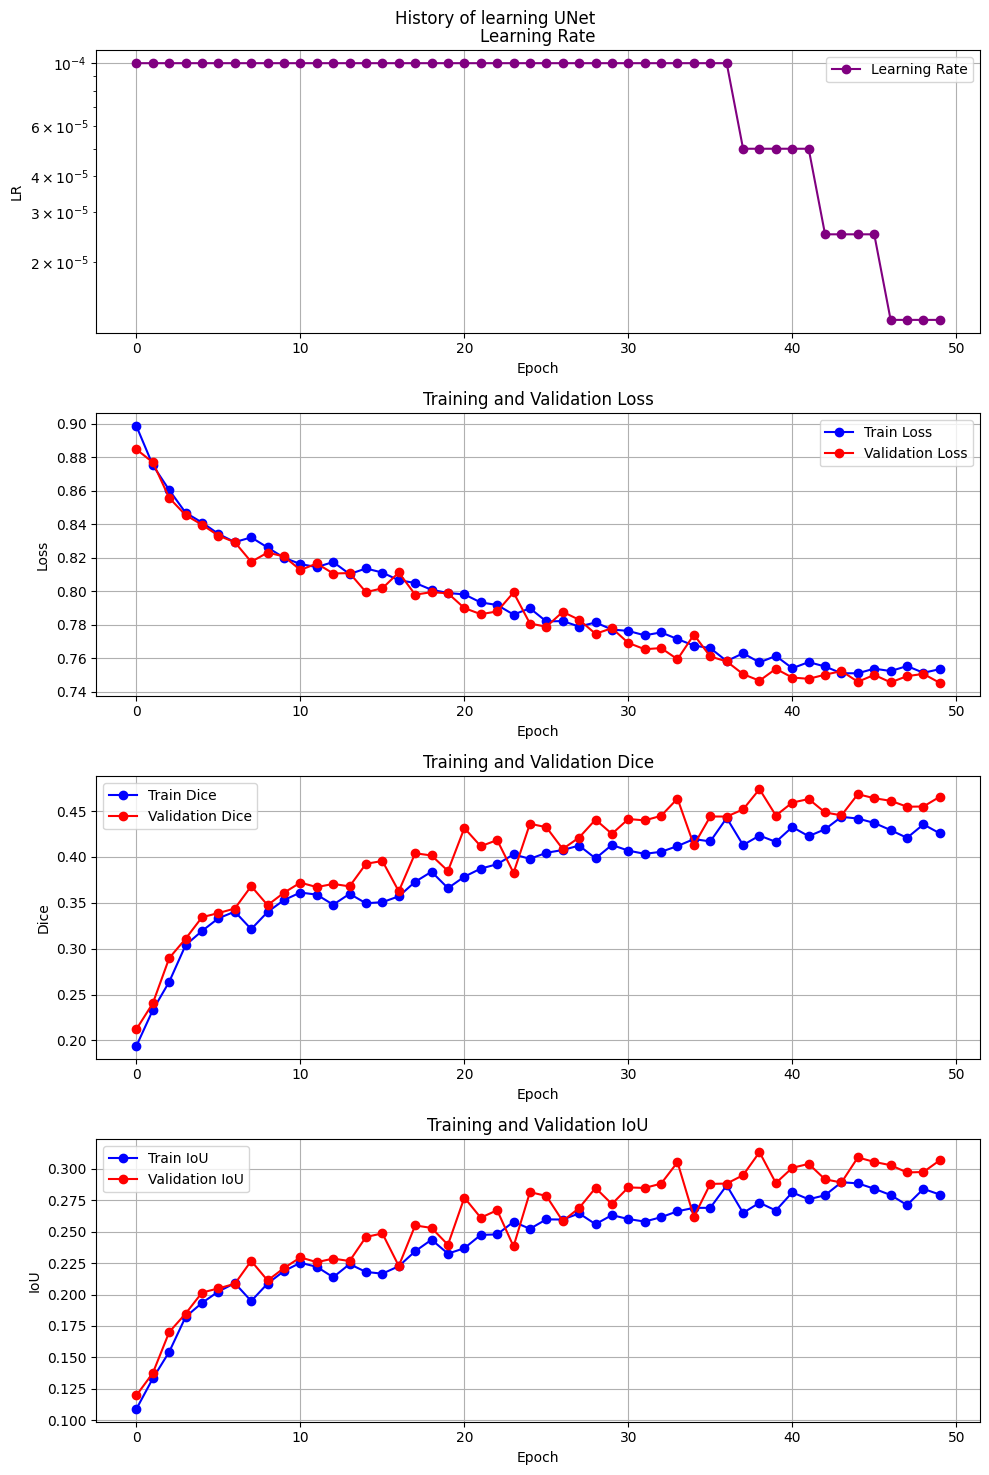

In [323]:
plot_training_history_2(history_ResNet_UNet_A)

In [324]:
max_val_dice = max(history_ResNet_UNet_A['val_dice'])
idx = history_ResNet_UNet_A['val_dice'].index(max_val_dice)
train_dice = history_ResNet_UNet_A['train_dice'][idx]

train_loss = history_ResNet_UNet_A['train_loss'][idx]
val_loss = history_ResNet_UNet_A['val_loss'][idx]

train_iou = history_ResNet_UNet_A['train_iou'][idx]
val_iou = history_ResNet_UNet_A['val_iou'][idx]

val_acc = history_ResNet_UNet_A['val_acc'][idx]

print('Лучший результат:')
print(f'Epoch      : {idx+1}')
print(f'Train dice : {train_dice:.4f}')
print(f'Val dice   : {max_val_dice:.4f}')
print(f'Train loss : {train_loss:.4f}')
print(f'Val loss   : {val_loss:.4f}')
print(f'Train IoU  : {train_iou:.4f}')
print(f'Val IoU    : {val_iou:.4f}')
print(f'Val Acc    : {val_acc}')

Лучший результат:
Epoch      : 39
Train dice : 0.4233
Val dice   : 0.4739
Train loss : 0.7574
Val loss   : 0.7465
Train IoU  : 0.2730
Val IoU    : 0.3132
Val Acc    : 0.8598052978515625


In [325]:
params = f'{sum(p.numel() for p in ResNet_UNet_A.parameters())/1000000:.2f}M'
epoch = len(history_ResNet_UNet_A['val_dice'])

max_val_dice = max(history_ResNet_UNet_A['val_dice'])
idx = history_ResNet_UNet_A['val_dice'].index(max_val_dice)

train_dice = history_ResNet_UNet_A['train_dice'][idx]

train_loss = history_ResNet_UNet_A['train_loss'][idx]
val_loss = history_ResNet_UNet_A['val_loss'][idx]

train_iou = history_ResNet_UNet_A['train_iou'][idx]
val_iou = history_ResNet_UNet_A['val_iou'][idx]

val_acc = history_ResNet_UNet_A['val_acc'][idx]

df_results.loc[len(df_results)] = ['history_ResNet_UNet_A', params , epoch, train_dice, max_val_dice, train_loss, val_loss, train_iou, val_iou, val_acc, idx + 1]
df_results.head()

model Количество параметров  Кол-во эпох  Train Dice  \
0              Base UNet                 2.47M           50    0.444274   
1  history_ResNet_UNet_A                 6.23M           50    0.423310   

   Val Dice  Train Loss  Val Loss  Train IoU   Val IoU   Val Acc  \
0  0.486969    0.772027  0.755854    0.29236  0.325400  0.883151   
1  0.473861    0.757442  0.746513    0.27296  0.313193  0.859805   

   Эпоха по макс Val Dice  
0                      20  
1                      39

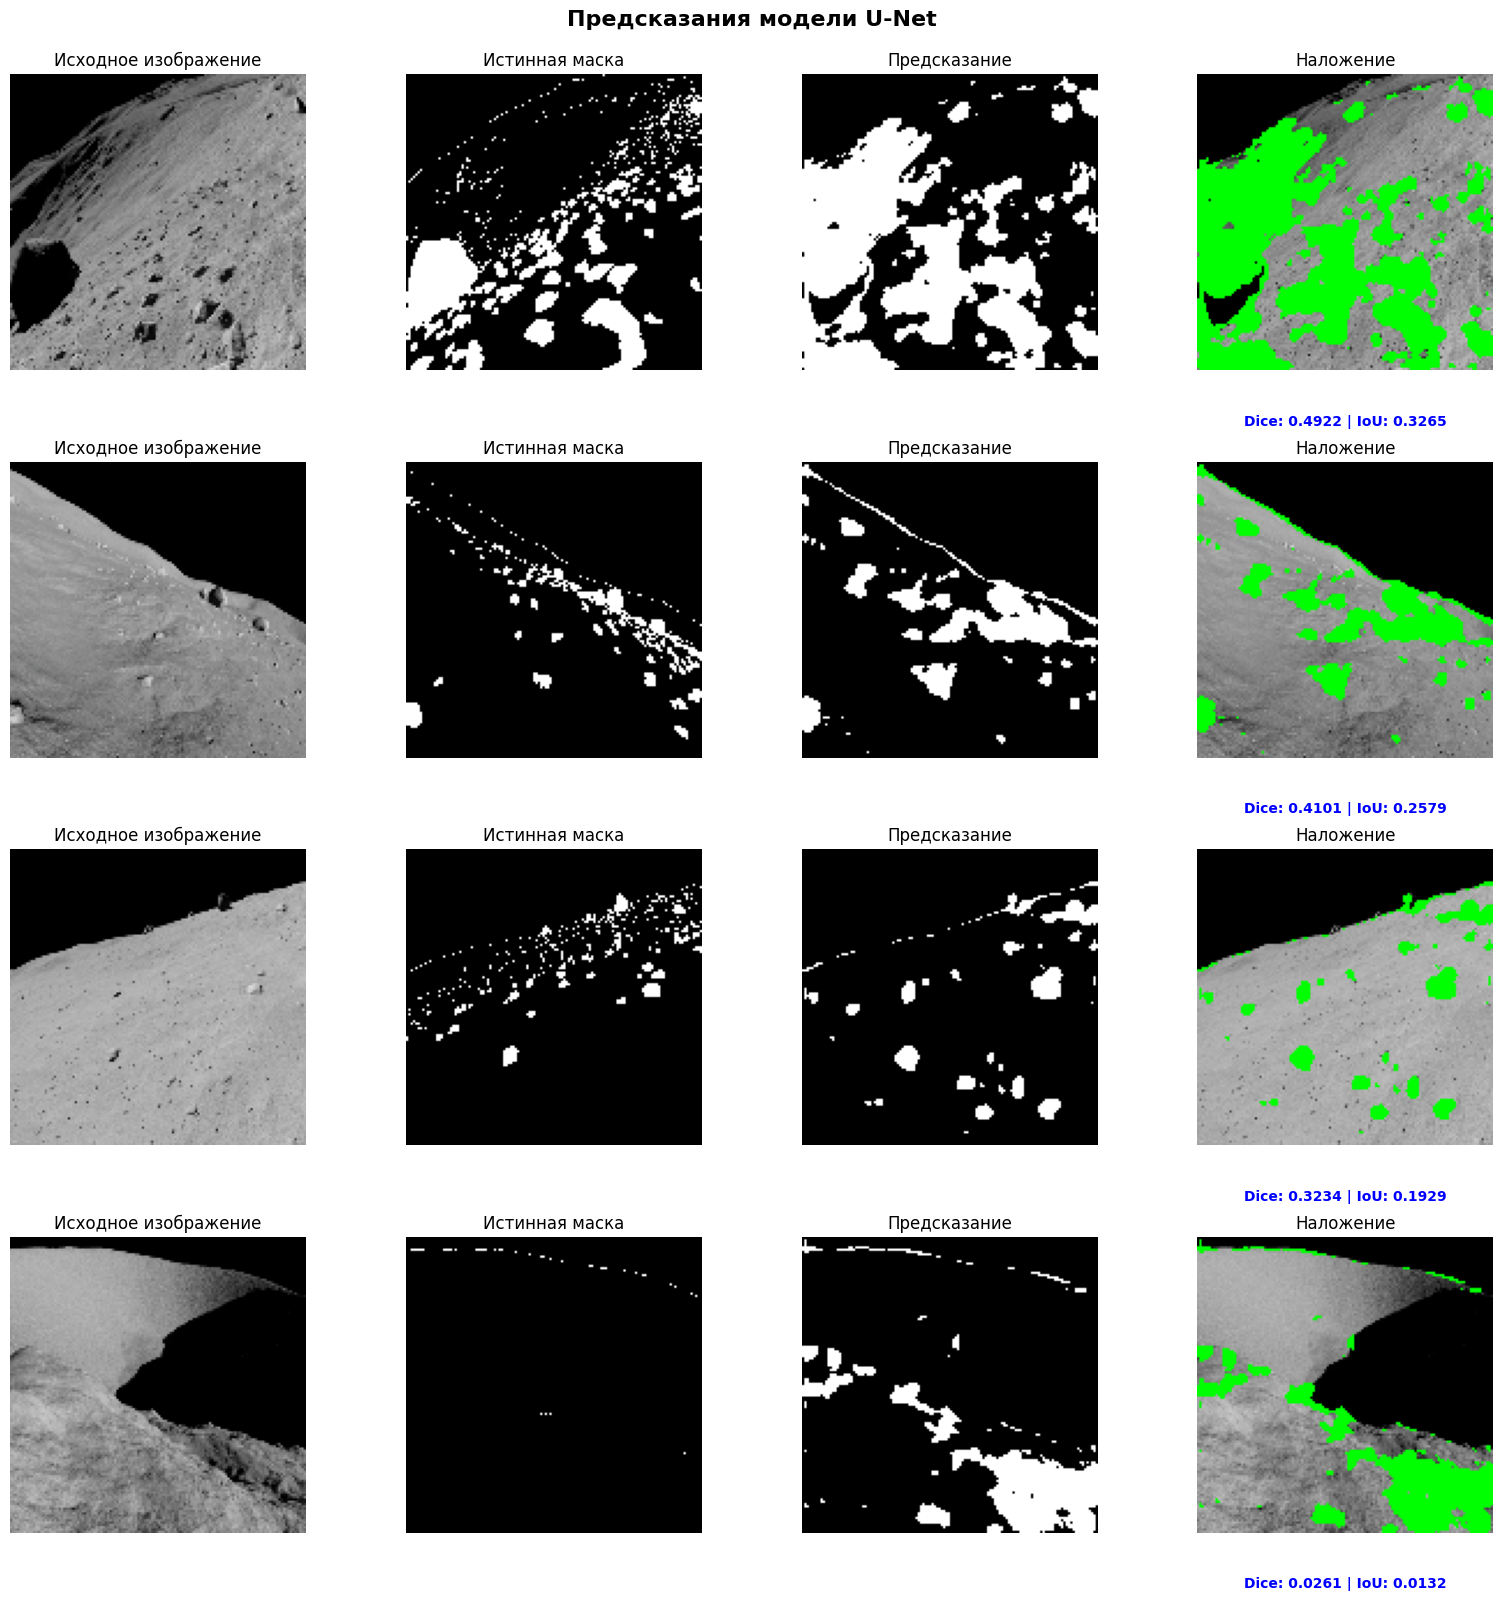

In [326]:
visualize_predictions(ResNet_UNet_A, val_loader, device, num_samples=4)

## Вариант B (тонкая настройка): полностью разморозить энкодер на поздних этапах.

In [327]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"  Используем устройство: {device}")

ResNet_UNet_B = ResNetUNet_A(out_channels=1, state_dict=torch.load("result_model_t3.pth", map_location=torch.device("cpu")))
for param in ResNet_UNet_B.encoder_blocks.parameters():
    param.requires_grad = True
    
print(f"   Обучаемых параметров: {sum(p.numel() for p in ResNet_UNet_B.parameters() if p.requires_grad):,}")

criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
encoder_params = []
decoder_params = []

for name, param in ResNet_UNet_B.named_parameters():
    if 'encoder' in name:
        encoder_params.append(param)
    else:
        decoder_params.append(param)

optimizer = torch.optim.Adam([{'params': encoder_params, 'lr': 1e-5}, {'params': decoder_params, 'lr': 1e-4}], weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
)

history_ResNet_UNet_B = train_model(
    model=ResNet_UNet_B,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=50,
    save_path='best_moon_ResNet_Unet_B.pth'
)

  Используем устройство: cpu
Параметров: 6,232,097
Уровней encoder: 4
Конфигурация каналов: [32, 64, 128, 256]
   Обучаемых параметров: 6,232,097
Эпоха 1/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.98it/s, loss=0.8625, dice=0.3078, iou=0.1819, acc=0.7778]



 Результаты эпохи 1:
  Train - Loss: 0.8572, Dice: 0.2489, IoU: 0.1464
  Val   - Loss: 0.8564, Dice: 0.3107, IoU: 0.1847, Acc: 0.7198
  LR: 0.000010
  Сохранена лучшая модель! Dice: 0.3107
Эпоха 2/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.19it/s, loss=0.8261, dice=0.3563, iou=0.2168, acc=0.7506]



 Результаты эпохи 2:
  Train - Loss: 0.8349, Dice: 0.3196, IoU: 0.1927
  Val   - Loss: 0.8330, Dice: 0.3169, IoU: 0.1890, Acc: 0.6707
  LR: 0.000010
  Сохранена лучшая модель! Dice: 0.3169
Эпоха 3/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.08it/s, loss=0.8014, dice=0.3884, iou=0.2410, acc=0.7948]



 Результаты эпохи 3:
  Train - Loss: 0.8162, Dice: 0.3516, IoU: 0.2156
  Val   - Loss: 0.8134, Dice: 0.3386, IoU: 0.2046, Acc: 0.7133
  LR: 0.000010
  Сохранена лучшая модель! Dice: 0.3386
Эпоха 4/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.18it/s, loss=0.7972, dice=0.3725, iou=0.2289, acc=0.8105]



 Результаты эпохи 4:
  Train - Loss: 0.8091, Dice: 0.3427, IoU: 0.2105
  Val   - Loss: 0.8027, Dice: 0.3519, IoU: 0.2148, Acc: 0.7537
  LR: 0.000010
  Сохранена лучшая модель! Dice: 0.3519
Эпоха 5/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.17it/s, loss=0.7970, dice=0.3848, iou=0.2383, acc=0.8047]



 Результаты эпохи 5:
  Train - Loss: 0.8059, Dice: 0.3488, IoU: 0.2148
  Val   - Loss: 0.8039, Dice: 0.3501, IoU: 0.2135, Acc: 0.7330
  LR: 0.000010
Эпоха 6/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.07it/s, loss=0.7828, dice=0.4044, iou=0.2535, acc=0.8174]



 Результаты эпохи 6:
  Train - Loss: 0.8012, Dice: 0.3648, IoU: 0.2283
  Val   - Loss: 0.7921, Dice: 0.3757, IoU: 0.2329, Acc: 0.7676
  LR: 0.000010
  Сохранена лучшая модель! Dice: 0.3757
Эпоха 7/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.92it/s, loss=0.7770, dice=0.4147, iou=0.2616, acc=0.8260]



 Результаты эпохи 7:
  Train - Loss: 0.7987, Dice: 0.3666, IoU: 0.2298
  Val   - Loss: 0.7880, Dice: 0.3813, IoU: 0.2373, Acc: 0.7777
  LR: 0.000010
  Сохранена лучшая модель! Dice: 0.3813
Эпоха 8/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.15it/s, loss=0.7767, dice=0.4355, iou=0.2784, acc=0.8767]



 Результаты эпохи 8:
  Train - Loss: 0.7938, Dice: 0.3713, IoU: 0.2330
  Val   - Loss: 0.7820, Dice: 0.4039, IoU: 0.2548, Acc: 0.8144
  LR: 0.000010
  Сохранена лучшая модель! Dice: 0.4039
Эпоха 9/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.11it/s, loss=0.7786, dice=0.4182, iou=0.2644, acc=0.8423]



 Результаты эпохи 9:
  Train - Loss: 0.7909, Dice: 0.3791, IoU: 0.2364
  Val   - Loss: 0.7849, Dice: 0.3918, IoU: 0.2457, Acc: 0.7926
  LR: 0.000010
Эпоха 10/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.00it/s, loss=0.7729, dice=0.4355, iou=0.2784, acc=0.8470]



 Результаты эпохи 10:
  Train - Loss: 0.7914, Dice: 0.3736, IoU: 0.2384
  Val   - Loss: 0.7807, Dice: 0.4027, IoU: 0.2544, Acc: 0.8015
  LR: 0.000010
Эпоха 11/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.14it/s, loss=0.7712, dice=0.4373, iou=0.2799, acc=0.8624]



 Результаты эпохи 11:
  Train - Loss: 0.7822, Dice: 0.3926, IoU: 0.2529
  Val   - Loss: 0.7774, Dice: 0.4111, IoU: 0.2610, Acc: 0.8178
  LR: 0.000010
  Сохранена лучшая модель! Dice: 0.4111
Эпоха 12/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.17it/s, loss=0.7622, dice=0.4428, iou=0.2844, acc=0.8483]



 Результаты эпохи 12:
  Train - Loss: 0.7752, Dice: 0.4179, IoU: 0.2692
  Val   - Loss: 0.7756, Dice: 0.4093, IoU: 0.2601, Acc: 0.8130
  LR: 0.000010
Эпоха 13/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.75it/s, loss=0.7705, dice=0.4308, iou=0.2745, acc=0.8609]



 Результаты эпохи 13:
  Train - Loss: 0.7746, Dice: 0.4095, IoU: 0.2626
  Val   - Loss: 0.7791, Dice: 0.3988, IoU: 0.2507, Acc: 0.8056
  LR: 0.000010
Эпоха 14/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.04it/s, loss=0.7670, dice=0.4613, iou=0.2998, acc=0.8710]



 Результаты эпохи 14:
  Train - Loss: 0.7763, Dice: 0.3976, IoU: 0.2531
  Val   - Loss: 0.7723, Dice: 0.4347, IoU: 0.2806, Acc: 0.8387
  LR: 0.000010
  Сохранена лучшая модель! Dice: 0.4347
Эпоха 15/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.24it/s, loss=0.7612, dice=0.4239, iou=0.2689, acc=0.8450]



 Результаты эпохи 15:
  Train - Loss: 0.7742, Dice: 0.4067, IoU: 0.2607
  Val   - Loss: 0.7739, Dice: 0.4009, IoU: 0.2526, Acc: 0.8060
  LR: 0.000010
Эпоха 16/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.89it/s, loss=0.7552, dice=0.4657, iou=0.3036, acc=0.8640]



 Результаты эпохи 16:
  Train - Loss: 0.7662, Dice: 0.4301, IoU: 0.2788
  Val   - Loss: 0.7694, Dice: 0.4198, IoU: 0.2679, Acc: 0.8151
  LR: 0.000010
Эпоха 17/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.80it/s, loss=0.7555, dice=0.4681, iou=0.3056, acc=0.8907]



 Результаты эпохи 17:
  Train - Loss: 0.7632, Dice: 0.4294, IoU: 0.2773
  Val   - Loss: 0.7605, Dice: 0.4444, IoU: 0.2888, Acc: 0.8533
  LR: 0.000010
  Сохранена лучшая модель! Dice: 0.4444
Эпоха 18/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.17it/s, loss=0.7560, dice=0.4499, iou=0.2902, acc=0.8841]



 Результаты эпохи 18:
  Train - Loss: 0.7662, Dice: 0.4228, IoU: 0.2728
  Val   - Loss: 0.7614, Dice: 0.4306, IoU: 0.2764, Acc: 0.8360
  LR: 0.000010
Эпоха 19/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.27it/s, loss=0.7500, dice=0.4425, iou=0.2841, acc=0.8362]



 Результаты эпохи 19:
  Train - Loss: 0.7590, Dice: 0.4308, IoU: 0.2798
  Val   - Loss: 0.7659, Dice: 0.4053, IoU: 0.2568, Acc: 0.7961
  LR: 0.000010
Эпоха 20/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.09it/s, loss=0.7440, dice=0.4859, iou=0.3209, acc=0.8789]



 Результаты эпохи 20:
  Train - Loss: 0.7635, Dice: 0.4050, IoU: 0.2618
  Val   - Loss: 0.7512, Dice: 0.4596, IoU: 0.3028, Acc: 0.8601
  LR: 0.000010
  Сохранена лучшая модель! Dice: 0.4596
Эпоха 21/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.15it/s, loss=0.7433, dice=0.4463, iou=0.2872, acc=0.8407]



 Результаты эпохи 21:
  Train - Loss: 0.7579, Dice: 0.4278, IoU: 0.2767
  Val   - Loss: 0.7535, Dice: 0.4258, IoU: 0.2736, Acc: 0.8243
  LR: 0.000010
Эпоха 22/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.16it/s, loss=0.7420, dice=0.4740, iou=0.3106, acc=0.8720]



 Результаты эпохи 22:
  Train - Loss: 0.7584, Dice: 0.4160, IoU: 0.2682
  Val   - Loss: 0.7509, Dice: 0.4491, IoU: 0.2926, Acc: 0.8471
  LR: 0.000010
Эпоха 23/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.16it/s, loss=0.7353, dice=0.4758, iou=0.3122, acc=0.8866]



 Результаты эпохи 23:
  Train - Loss: 0.7547, Dice: 0.4263, IoU: 0.2760
  Val   - Loss: 0.7437, Dice: 0.4578, IoU: 0.3008, Acc: 0.8566
  LR: 0.000010
Эпоха 24/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.62it/s, loss=0.7302, dice=0.4852, iou=0.3203, acc=0.8719]



 Результаты эпохи 24:
  Train - Loss: 0.7505, Dice: 0.4316, IoU: 0.2813
  Val   - Loss: 0.7447, Dice: 0.4502, IoU: 0.2941, Acc: 0.8450
  LR: 0.000005
Эпоха 25/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.07it/s, loss=0.7247, dice=0.5016, iou=0.3348, acc=0.8895]



 Результаты эпохи 25:
  Train - Loss: 0.7542, Dice: 0.4157, IoU: 0.2694
  Val   - Loss: 0.7368, Dice: 0.4676, IoU: 0.3088, Acc: 0.8596
  LR: 0.000005
  Сохранена лучшая модель! Dice: 0.4676
Эпоха 26/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.02it/s, loss=0.7260, dice=0.4876, iou=0.3224, acc=0.8756]



 Результаты эпохи 26:
  Train - Loss: 0.7523, Dice: 0.4196, IoU: 0.2711
  Val   - Loss: 0.7373, Dice: 0.4606, IoU: 0.3032, Acc: 0.8562
  LR: 0.000005
Эпоха 27/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.75it/s, loss=0.7319, dice=0.4810, iou=0.3166, acc=0.8692]



 Результаты эпохи 27:
  Train - Loss: 0.7364, Dice: 0.4709, IoU: 0.3130
  Val   - Loss: 0.7417, Dice: 0.4556, IoU: 0.2984, Acc: 0.8479
  LR: 0.000005
Эпоха 28/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.63it/s, loss=0.7292, dice=0.4917, iou=0.3260, acc=0.8789]



 Результаты эпохи 28:
  Train - Loss: 0.7388, Dice: 0.4595, IoU: 0.3026
  Val   - Loss: 0.7393, Dice: 0.4590, IoU: 0.3011, Acc: 0.8509
  LR: 0.000005
Эпоха 29/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.56it/s, loss=0.7312, dice=0.4716, iou=0.3085, acc=0.8625]



 Результаты эпохи 29:
  Train - Loss: 0.7408, Dice: 0.4469, IoU: 0.2903
  Val   - Loss: 0.7444, Dice: 0.4391, IoU: 0.2841, Acc: 0.8321
  LR: 0.000003
Эпоха 30/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.72it/s, loss=0.7307, dice=0.4663, iou=0.3040, acc=0.8594]



 Результаты эпохи 30:
  Train - Loss: 0.7413, Dice: 0.4418, IoU: 0.2887
  Val   - Loss: 0.7431, Dice: 0.4397, IoU: 0.2850, Acc: 0.8333
  LR: 0.000003
Эпоха 31/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.91it/s, loss=0.7274, dice=0.4805, iou=0.3162, acc=0.8692]



 Результаты эпохи 31:
  Train - Loss: 0.7370, Dice: 0.4546, IoU: 0.2991
  Val   - Loss: 0.7383, Dice: 0.4539, IoU: 0.2975, Acc: 0.8491
  LR: 0.000003
Эпоха 32/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.99it/s, loss=0.7230, dice=0.4872, iou=0.3221, acc=0.8730]



 Результаты эпохи 32:
  Train - Loss: 0.7446, Dice: 0.4320, IoU: 0.2799
  Val   - Loss: 0.7335, Dice: 0.4622, IoU: 0.3047, Acc: 0.8598
  LR: 0.000003
Эпоха 33/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.91it/s, loss=0.7217, dice=0.5099, iou=0.3422, acc=0.8966]



 Результаты эпохи 33:
  Train - Loss: 0.7364, Dice: 0.4565, IoU: 0.3012
  Val   - Loss: 0.7302, Dice: 0.4787, IoU: 0.3183, Acc: 0.8696
  LR: 0.000003
  Сохранена лучшая модель! Dice: 0.4787
Эпоха 34/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.40it/s, loss=0.7224, dice=0.5020, iou=0.3351, acc=0.8896]



 Результаты эпохи 34:
  Train - Loss: 0.7407, Dice: 0.4414, IoU: 0.2903
  Val   - Loss: 0.7304, Dice: 0.4779, IoU: 0.3179, Acc: 0.8686
  LR: 0.000003
Эпоха 35/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.72it/s, loss=0.7281, dice=0.4817, iou=0.3172, acc=0.8690]



 Результаты эпохи 35:
  Train - Loss: 0.7340, Dice: 0.4607, IoU: 0.3082
  Val   - Loss: 0.7372, Dice: 0.4549, IoU: 0.2982, Acc: 0.8463
  LR: 0.000003
Эпоха 36/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.86it/s, loss=0.7222, dice=0.4944, iou=0.3283, acc=0.8778]



 Результаты эпохи 36:
  Train - Loss: 0.7429, Dice: 0.4295, IoU: 0.2793
  Val   - Loss: 0.7339, Dice: 0.4615, IoU: 0.3038, Acc: 0.8490
  LR: 0.000003
Эпоха 37/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.97it/s, loss=0.7195, dice=0.5075, iou=0.3400, acc=0.8894]



 Результаты эпохи 37:
  Train - Loss: 0.7267, Dice: 0.4812, IoU: 0.3204
  Val   - Loss: 0.7307, Dice: 0.4709, IoU: 0.3117, Acc: 0.8585
  LR: 0.000001
Эпоха 38/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.20it/s, loss=0.7173, dice=0.5133, iou=0.3453, acc=0.8931]



 Результаты эпохи 38:
  Train - Loss: 0.7384, Dice: 0.4481, IoU: 0.2928
  Val   - Loss: 0.7293, Dice: 0.4725, IoU: 0.3131, Acc: 0.8601
  LR: 0.000001
Эпоха 39/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.87it/s, loss=0.7180, dice=0.5115, iou=0.3436, acc=0.8906]



 Результаты эпохи 39:
  Train - Loss: 0.7377, Dice: 0.4452, IoU: 0.2931
  Val   - Loss: 0.7300, Dice: 0.4721, IoU: 0.3128, Acc: 0.8588
  LR: 0.000001
Эпоха 40/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.26it/s, loss=0.7185, dice=0.5200, iou=0.3513, acc=0.8997]



 Результаты эпохи 40:
  Train - Loss: 0.7332, Dice: 0.4641, IoU: 0.3081
  Val   - Loss: 0.7272, Dice: 0.4864, IoU: 0.3253, Acc: 0.8737
  LR: 0.000001
  Сохранена лучшая модель! Dice: 0.4864
Эпоха 41/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.34it/s, loss=0.7152, dice=0.5171, iou=0.3487, acc=0.8922]



 Результаты эпохи 41:
  Train - Loss: 0.7395, Dice: 0.4385, IoU: 0.2858
  Val   - Loss: 0.7285, Dice: 0.4752, IoU: 0.3158, Acc: 0.8627
  LR: 0.000001
Эпоха 42/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.31it/s, loss=0.7149, dice=0.5170, iou=0.3486, acc=0.8952]



 Результаты эпохи 42:
  Train - Loss: 0.7328, Dice: 0.4646, IoU: 0.3102
  Val   - Loss: 0.7263, Dice: 0.4795, IoU: 0.3195, Acc: 0.8686
  LR: 0.000001
Эпоха 43/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.95it/s, loss=0.7166, dice=0.5139, iou=0.3458, acc=0.8947]



 Результаты эпохи 43:
  Train - Loss: 0.7285, Dice: 0.4750, IoU: 0.3174
  Val   - Loss: 0.7264, Dice: 0.4803, IoU: 0.3206, Acc: 0.8734
  LR: 0.000001
Эпоха 44/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.69it/s, loss=0.7172, dice=0.5070, iou=0.3396, acc=0.8849]



 Результаты эпохи 44:
  Train - Loss: 0.7349, Dice: 0.4491, IoU: 0.2958
  Val   - Loss: 0.7293, Dice: 0.4694, IoU: 0.3110, Acc: 0.8561
  LR: 0.000001
Эпоха 45/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.98it/s, loss=0.7158, dice=0.5111, iou=0.3433, acc=0.8932]



 Результаты эпохи 45:
  Train - Loss: 0.7327, Dice: 0.4544, IoU: 0.3002
  Val   - Loss: 0.7273, Dice: 0.4747, IoU: 0.3151, Acc: 0.8627
  LR: 0.000001
Эпоха 46/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.04it/s, loss=0.7185, dice=0.4895, iou=0.3241, acc=0.8735]



 Результаты эпохи 46:
  Train - Loss: 0.7339, Dice: 0.4484, IoU: 0.2947
  Val   - Loss: 0.7304, Dice: 0.4587, IoU: 0.3016, Acc: 0.8491
  LR: 0.000001
Эпоха 47/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  6.78it/s, loss=0.7143, dice=0.5122, iou=0.3443, acc=0.8875]



 Результаты эпохи 47:
  Train - Loss: 0.7388, Dice: 0.4380, IoU: 0.2893
  Val   - Loss: 0.7274, Dice: 0.4739, IoU: 0.3146, Acc: 0.8604
  LR: 0.000001
Эпоха 48/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.02it/s, loss=0.7160, dice=0.5059, iou=0.3386, acc=0.8802]



 Результаты эпохи 48:
  Train - Loss: 0.7365, Dice: 0.4402, IoU: 0.2889
  Val   - Loss: 0.7277, Dice: 0.4723, IoU: 0.3135, Acc: 0.8594
  LR: 0.000000
Эпоха 49/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.18it/s, loss=0.7185, dice=0.4995, iou=0.3329, acc=0.8753]



 Результаты эпохи 49:
  Train - Loss: 0.7329, Dice: 0.4545, IoU: 0.3015
  Val   - Loss: 0.7314, Dice: 0.4632, IoU: 0.3055, Acc: 0.8490
  LR: 0.000000
Эпоха 50/50


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.06it/s, loss=0.7162, dice=0.5071, iou=0.3397, acc=0.8852]


 Результаты эпохи 50:
  Train - Loss: 0.7345, Dice: 0.4473, IoU: 0.2948
  Val   - Loss: 0.7281, Dice: 0.4712, IoU: 0.3122, Acc: 0.8590
  LR: 0.000000
Лучший Val Dice: 0.4864


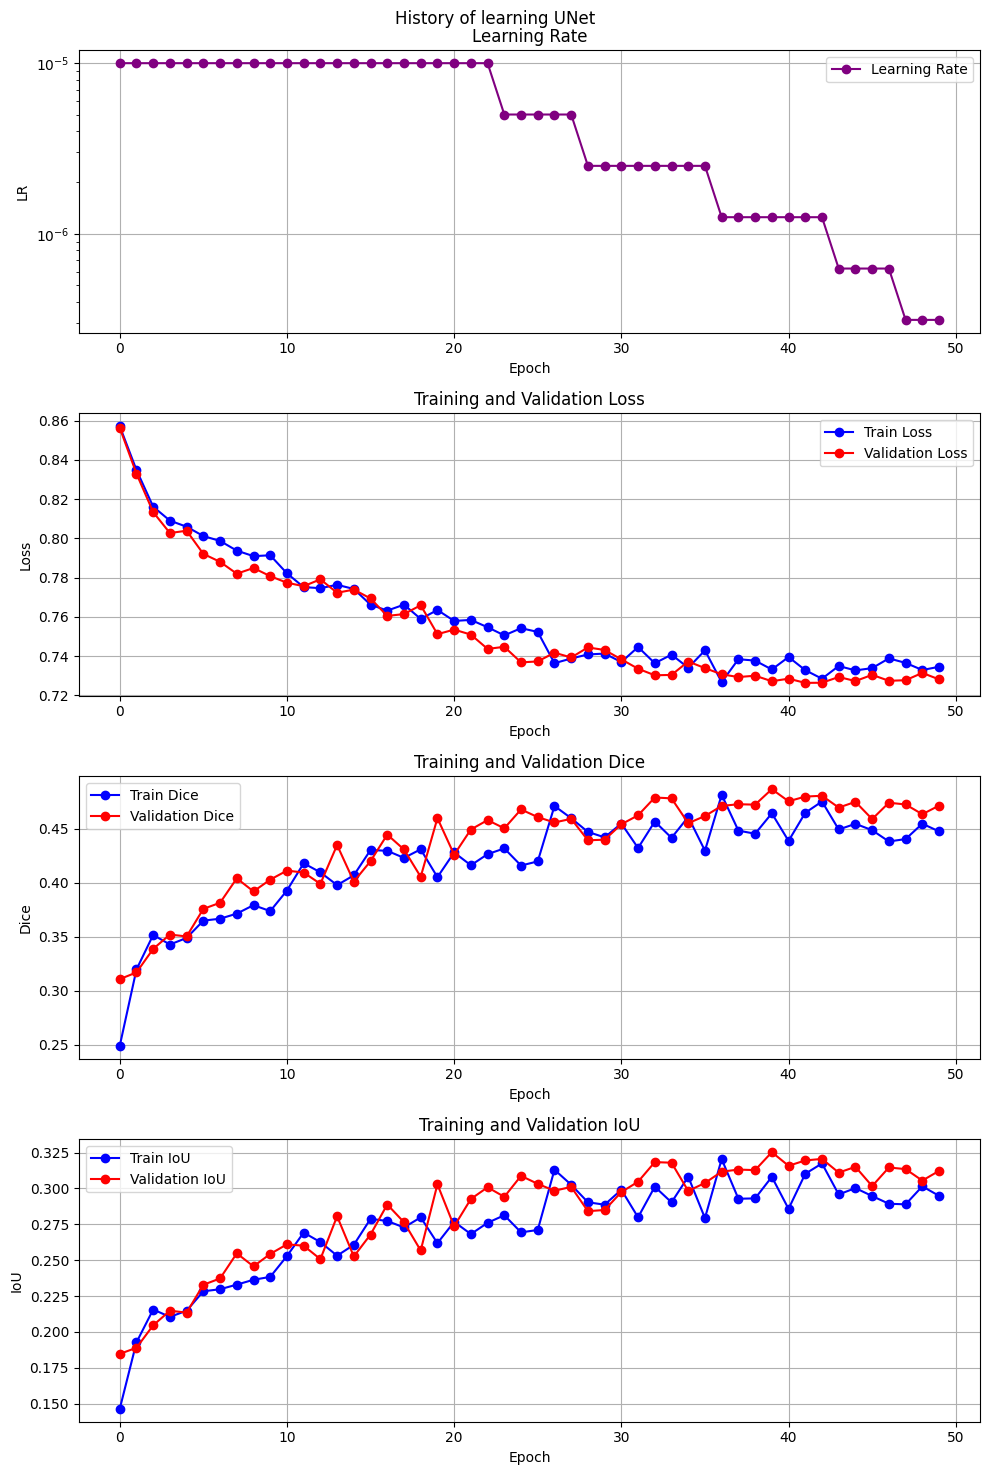

In [328]:
plot_training_history_2(history_ResNet_UNet_B)

In [329]:
max_val_dice = max(history_ResNet_UNet_B['val_dice'])
idx = history_ResNet_UNet_B['val_dice'].index(max_val_dice)
train_dice = history_ResNet_UNet_B['train_dice'][idx]

train_loss = history_ResNet_UNet_B['train_loss'][idx]
val_loss = history_ResNet_UNet_B['val_loss'][idx]

train_iou = history_ResNet_UNet_B['train_iou'][idx]
val_iou = history_ResNet_UNet_B['val_iou'][idx]

val_acc = history_ResNet_UNet_B['val_acc'][idx]

print('Лучший результат:')
print(f'Epoch      : {idx+1}')
print(f'Train dice : {train_dice:.4f}')
print(f'Val dice   : {max_val_dice:.4f}')
print(f'Train loss : {train_loss:.4f}')
print(f'Val loss   : {val_loss:.4f}')
print(f'Train IoU  : {train_iou:.4f}')
print(f'Val IoU    : {val_iou:.4f}')
print(f'Val Acc    : {val_acc}')

Лучший результат:
Epoch      : 40
Train dice : 0.4641
Val dice   : 0.4864
Train loss : 0.7332
Val loss   : 0.7272
Train IoU  : 0.3081
Val IoU    : 0.3253
Val Acc    : 0.8736724853515625


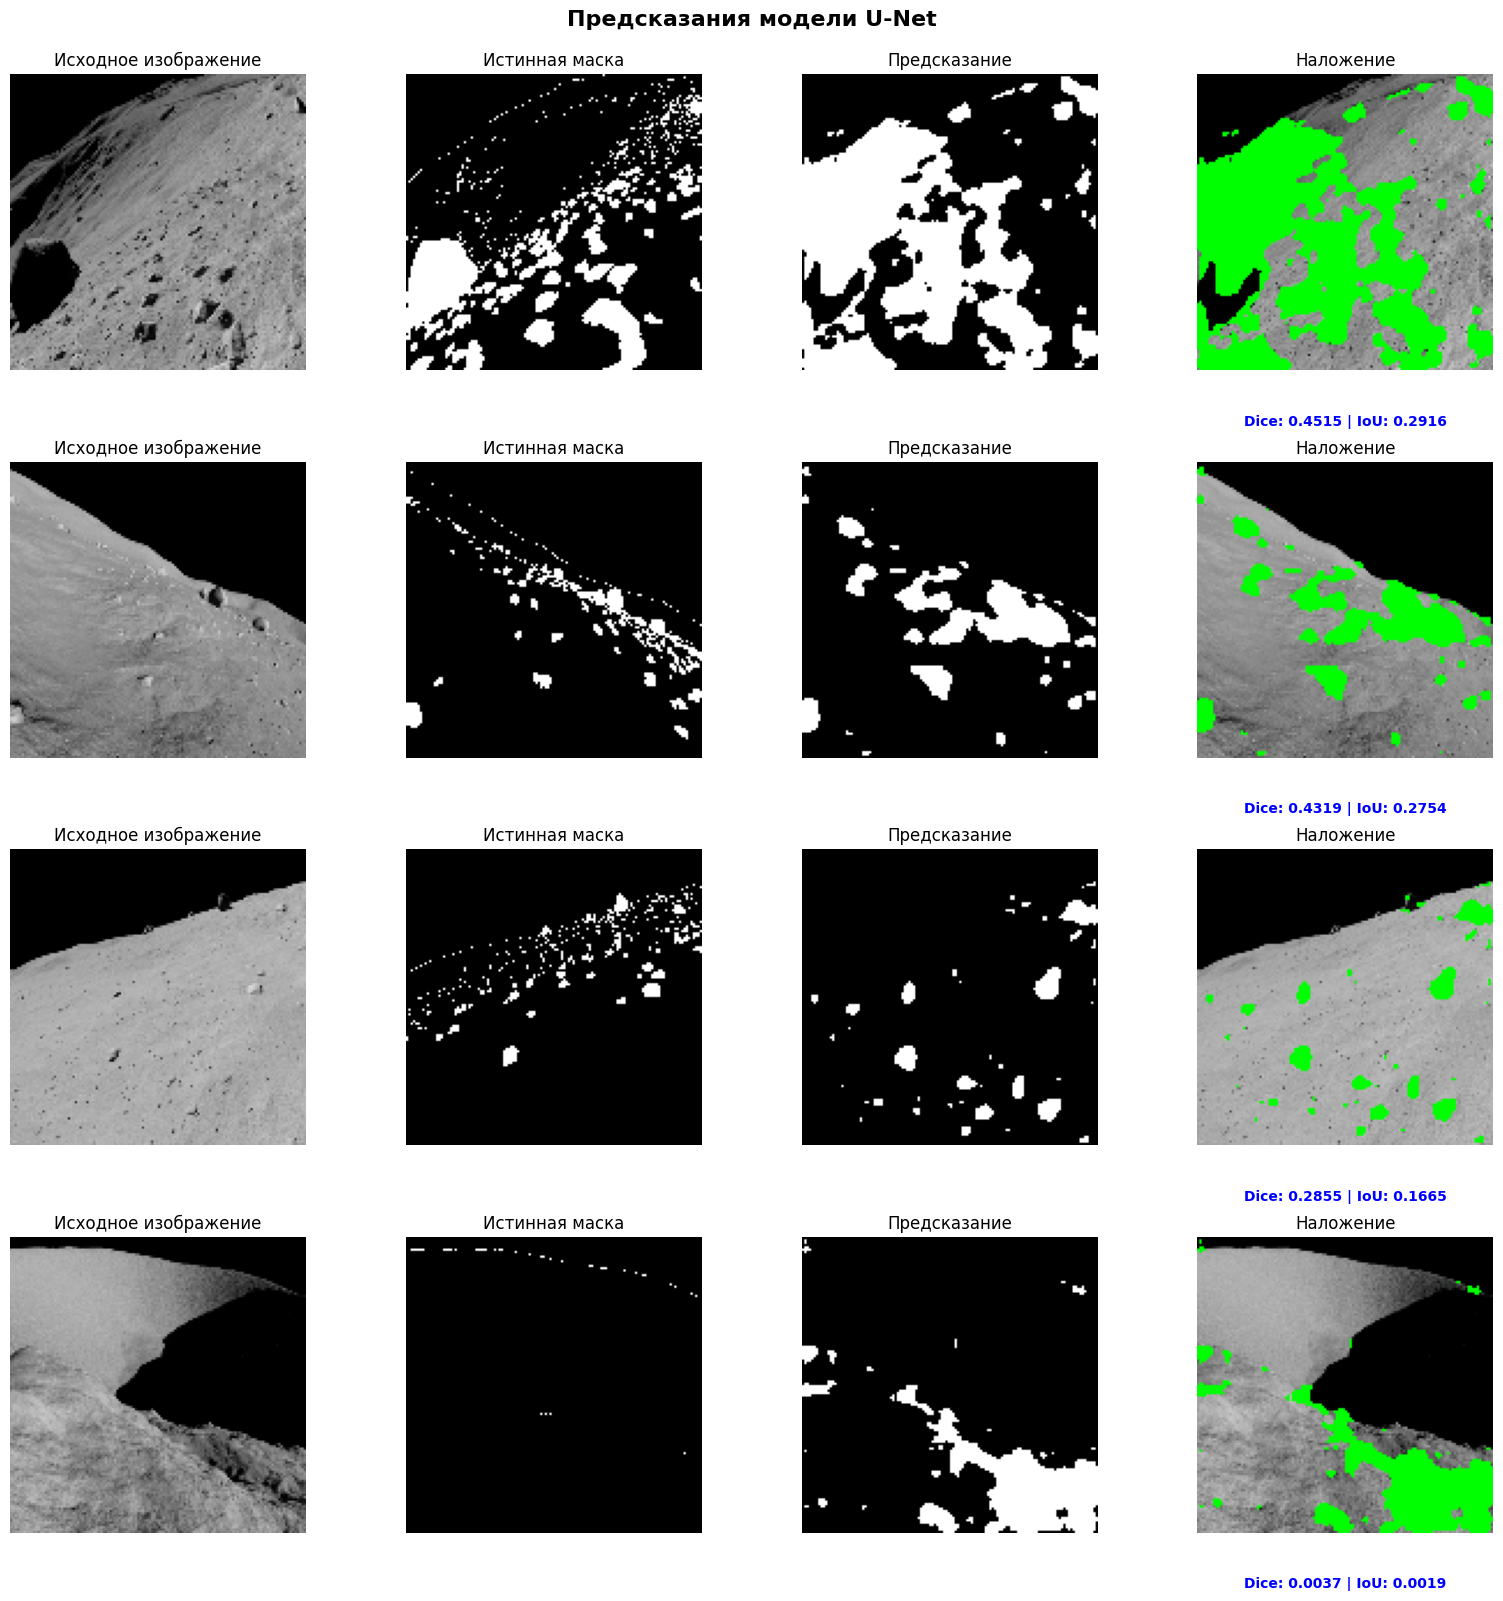

In [330]:
visualize_predictions(ResNet_UNet_B, val_loader, device, num_samples=4)

In [331]:
params = f'{sum(p.numel() for p in ResNet_UNet_B.parameters())/1000000:.2f}M'
epoch = len(history_ResNet_UNet_B['val_dice'])

max_val_dice = max(history_ResNet_UNet_B['val_dice'])
idx = history_ResNet_UNet_B['val_dice'].index(max_val_dice)

train_dice = history_ResNet_UNet_B['train_dice'][idx]

train_loss = history_ResNet_UNet_B['train_loss'][idx]
val_loss = history_ResNet_UNet_B['val_loss'][idx]

train_iou = history_ResNet_UNet_B['train_iou'][idx]
val_iou = history_ResNet_UNet_B['val_iou'][idx]

val_acc = history_ResNet_UNet_B['val_acc'][idx]

df_results.loc[len(df_results)] = ['history_ResNet_UNet_B', params , epoch, train_dice, max_val_dice, train_loss, val_loss, train_iou, val_iou, val_acc, idx + 1]
df_results.head()

model Количество параметров  Кол-во эпох  Train Dice  \
0              Base UNet                 2.47M           50    0.444274   
1  history_ResNet_UNet_A                 6.23M           50    0.423310   
2  history_ResNet_UNet_B                 6.23M           50    0.464065   

   Val Dice  Train Loss  Val Loss  Train IoU   Val IoU   Val Acc  \
0  0.486969    0.772027  0.755854   0.292360  0.325400  0.883151   
1  0.473861    0.757442  0.746513   0.272960  0.313193  0.859805   
2  0.486401    0.733157  0.727180   0.308056  0.325257  0.873672   

   Эпоха по макс Val Dice  
0                      20  
1                      39  
2                      40

# Сравнение моделей

In [339]:
def compare_models(simple_model, resnet_model, dataloader, device, num_samples=3, names=['UNet', 'ResNet_UNet']):

    simple_model.eval()
    resnet_model.eval()

    images_list = []
    masks_list = []

    for images, masks in dataloader:
        images_list.append(images)
        masks_list.append(masks)
        if sum(len(b) for b in images_list) >= num_samples:
            break

    images = torch.cat(images_list, dim=0)[:num_samples]
    masks = torch.cat(masks_list, dim=0)[:num_samples]
    images = images.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        simple_preds = simple_model(images)
        simple_preds = (simple_preds > 0.5).float()

        resnet_preds = resnet_model(images)
        resnet_preds = (resnet_preds > 0.5).float()

    images = images.cpu()
    masks = masks.cpu()
    simple_preds = simple_preds.cpu()
    resnet_preds = resnet_preds.cpu()

    fig, axes = plt.subplots(num_samples, 5, figsize=(16, 4*num_samples))

    for i in range(min(num_samples, len(images))):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        if masks.dim() == 4:  # [B, 1, H, W]
            mask_true = masks[i, 0].numpy()
        elif masks.dim() == 3:  # [B, H, W]
            mask_true = masks[i].numpy()
    
        simple_pred = simple_preds[i, 0].numpy()
        resnet_pred = resnet_preds[i, 0].numpy()

        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Исходное', fontsize=12)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask_true, cmap='gray')
        axes[i, 1].set_title('Ground Truth', fontsize=12)
        axes[i, 1].axis('off')

        axes[i, 2].imshow(simple_pred, cmap='gray')
        simple_dice = dice_coefficient(simple_preds[i:i+1], masks[i:i+1])
        simple_iou = iou_score(simple_preds[i:i+1], masks[i:i+1])
        axes[i, 2].set_title(f'{names[0]} \nDice: {simple_dice:.3f} | IoU: {simple_iou:.3f}', fontsize=10)
        axes[i, 2].axis('off')

        axes[i, 3].imshow(resnet_pred, cmap='gray')
        resnet_dice = dice_coefficient(resnet_preds[i:i+1], masks[i:i+1])
        resnet_iou = iou_score(resnet_preds[i:i+1], masks[i:i+1])
        axes[i, 3].set_title(f'{names[1]}\nDice: {resnet_dice:.3f} | IoU: {resnet_iou:.3f}', fontsize=10)
        axes[i, 3].axis('off')

        diff = np.abs(simple_pred - resnet_pred)
        axes[i, 4].imshow(diff, cmap='hot')
        axes[i, 4].set_title('Difference\n(white = disagree)', fontsize=10)
        axes[i, 4].axis('off')

    plt.suptitle(f'Сравнение моделей {names[0]} и {names[1]}', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

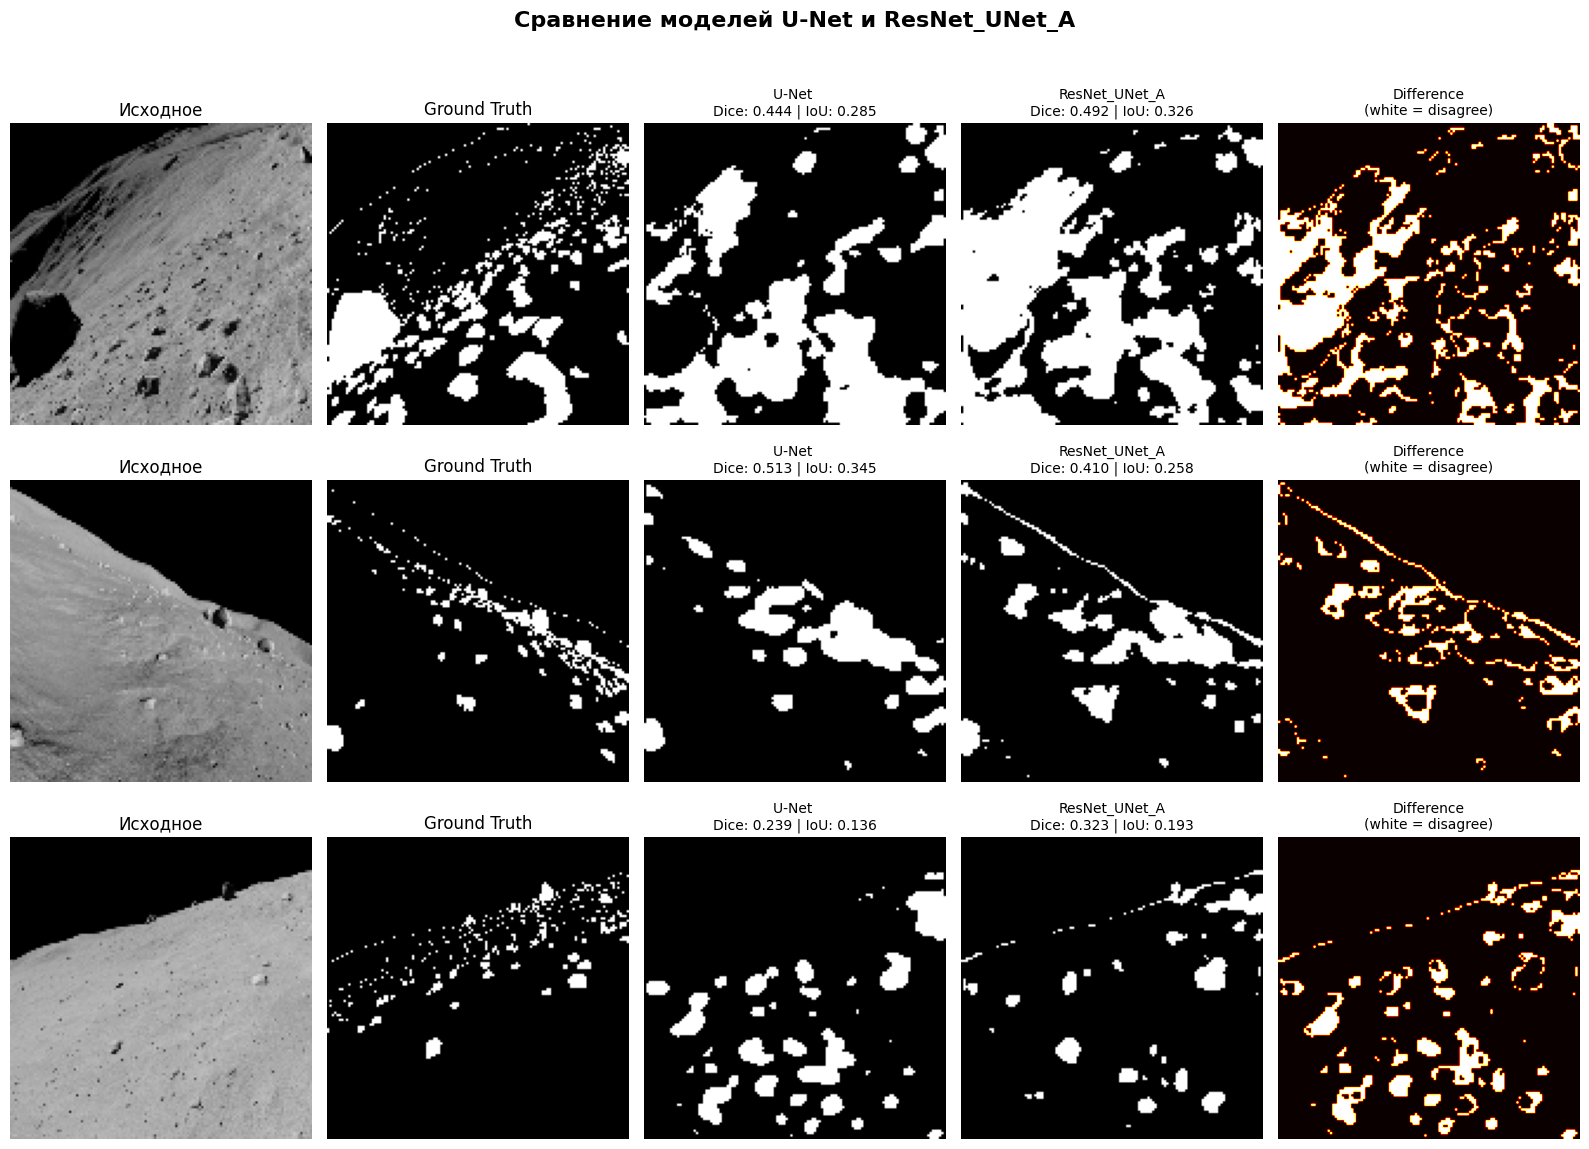

In [340]:
compare_models(model, ResNet_UNet_A, val_loader, device, num_samples=3, names=['U-Net', 'ResNet_UNet_A'])

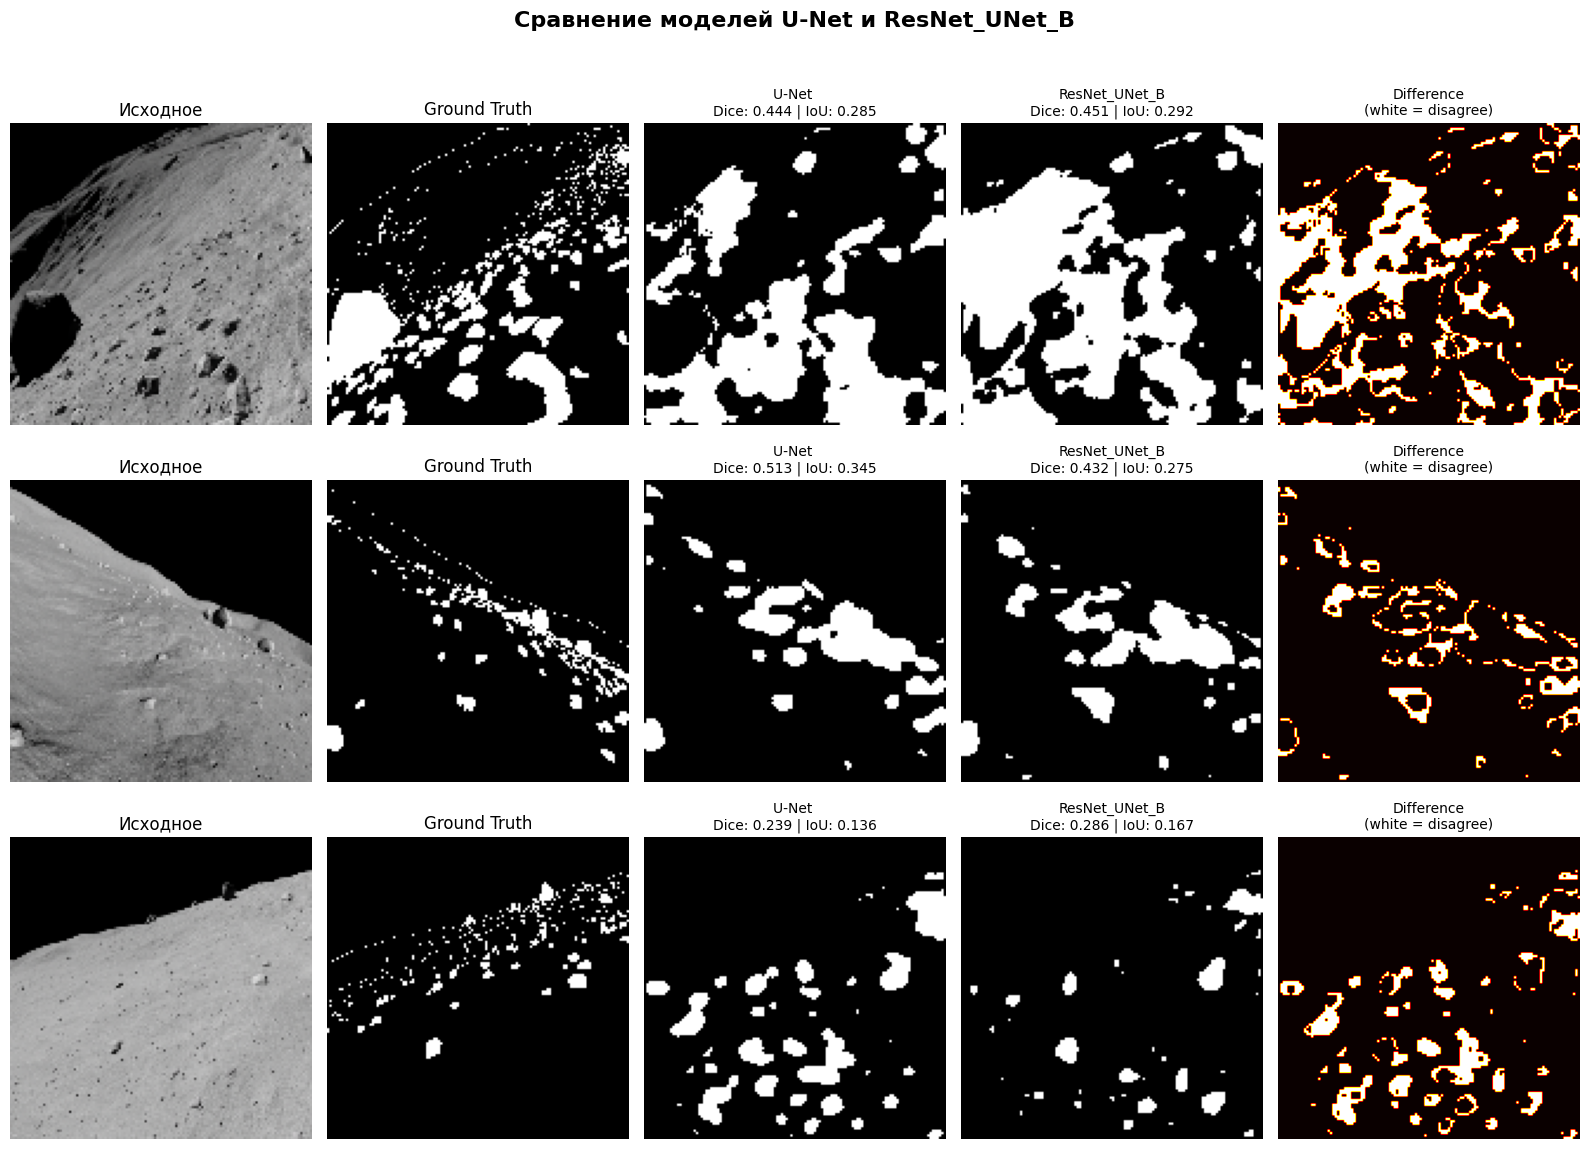

In [341]:
compare_models(model, ResNet_UNet_B, val_loader, device, num_samples=3, names=['U-Net', 'ResNet_UNet_B'])

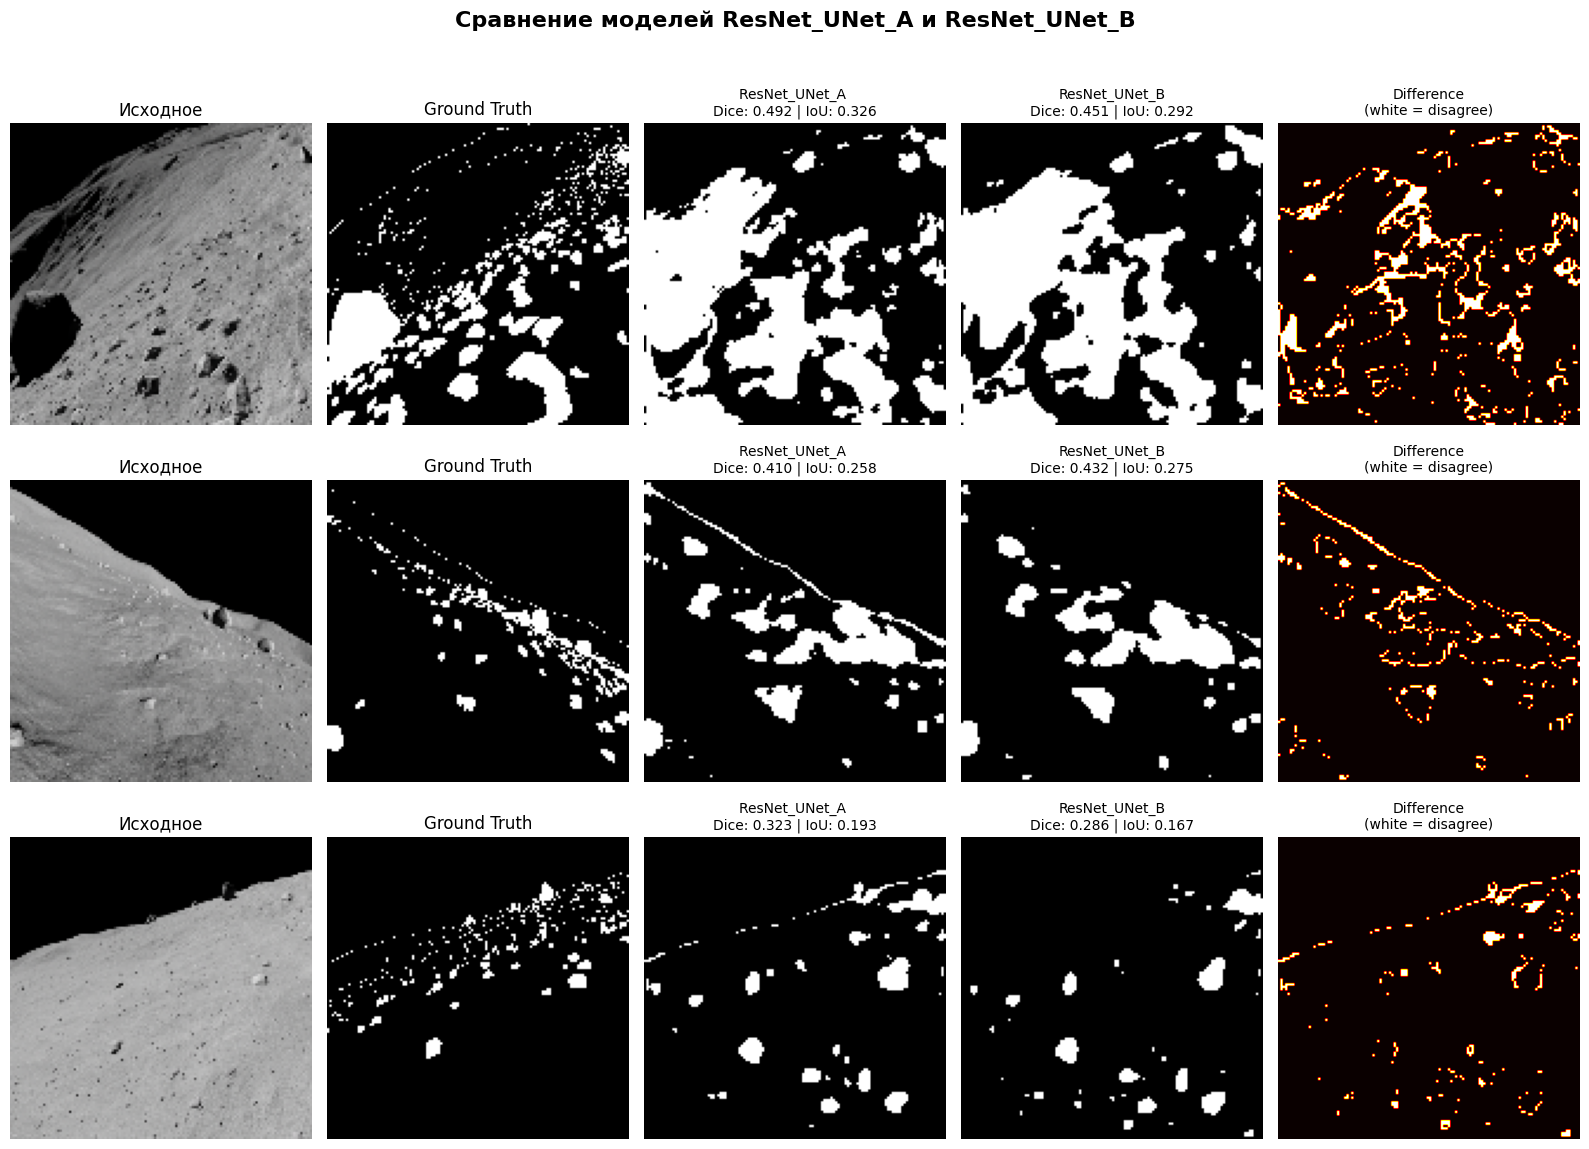

In [342]:
compare_models(ResNet_UNet_A, ResNet_UNet_B, val_loader, device, num_samples=3, names=['ResNet_UNet_A', 'ResNet_UNet_B'])

In [343]:
df_results.head()

model Количество параметров  Кол-во эпох  Train Dice  \
0              Base UNet                 2.47M           50    0.444274   
1  history_ResNet_UNet_A                 6.23M           50    0.423310   
2  history_ResNet_UNet_B                 6.23M           50    0.464065   

   Val Dice  Train Loss  Val Loss  Train IoU   Val IoU   Val Acc  \
0  0.486969    0.772027  0.755854   0.292360  0.325400  0.883151   
1  0.473861    0.757442  0.746513   0.272960  0.313193  0.859805   
2  0.486401    0.733157  0.727180   0.308056  0.325257  0.873672   

   Эпоха по макс Val Dice  
0                      20  
1                      39  
2                      40

**Отчет:**
1. Обучена модель **ResNet->[32-64-128-256][2, 2, 2, 2][ReLU]**  под разрешение **128х128** с использованием аугментации (аугментация позволила повысить точность модели, чем без нее).
2. Обучена модель **UNet** с архитектурой размером порядка **2.5М** параметров (пришлось изменить последнее количество каналов) на датасете "Луна". Модель оценивалась по таким метрикам как **IoU**, **Dice** и **Accuracy**. Отображены результаты работы модели на валидационной выборке.
3. Обучена модель с использованием **UNet и бэкбоном (ResNet)** в двух вариантах:
- **вариант А** (заморозка): заморозка энкодера, обучение только декодера
- **вариант B** (тонкая настройка): полностью разморозить энкодер на поздних этапах 

**Вывод**: 

1. В результате проведенных исследований лучшей моделью показала себя UNet с 2.5М параметрами, в то время как модель UNet с бэкбоном ResNet (в двух вариантах) имея на порядок больше параметов, показали себя хуже. Это обусловлено тем, что наш бэкбон изначально обучался на других данных и не смог оптимально настроить весовые коэффициенты.

2. Стоит отметить что UNet изначально обучалась на датасете "Луна", ввиду чего и показала себя лучше. Однако вариант использования UNet и бэкбона ResNet с размороженным энкодером в результате обучения и оценки был близок по точности с простой архитектурой UNet. 